<div class='alert alert-block alert-success' style="font-weight:bolder">

## Assignment #1

In this assigment, you are required to go through the fundamental steps involved in applying machine learning (ML) on [Glioma Grading Clinical and Mutation Features](https://archive.ics.uci.edu/dataset/759/glioma+grading+clinical+and+mutation+features+dataset). (Please refer to the link for the detailed description of the dataset)

The general steps should be followed as in the Lab1 notebook. Please keep in mind that since "Glioma Grading Clinical and Mutation Features" dataset is a classification task, you should consider different estimators and metrics to evaluate and perform model selection.

As mentioned in the lab, the goal is for you to get comfortable with reading the official documentations, and use online resources. 


For the convenience, we have provided the loading part of the dataset, using the **ucimlrepo** package 
</div>

In [1]:
#ALL THE IMPORTS
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from scipy.stats import ttest_rel
from sklearn import tree
from sklearn.metrics import recall_score
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 

from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import shap

from ucimlrepo import fetch_ucirepo
import ssl

#For exporting an interractive plot to web browser and displaying a printscreen of said plot
import webbrowser
from IPython.display import Image

from sklearn.model_selection import train_test_split
#copypasted most of this from documentaiton, removed a few scalers since scaling is weird in general for this task
from sklearn.preprocessing import ( 
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,)

from sklearn.compose import ColumnTransformer #no point in doing scaling for anything other than age

In [2]:


ssl._create_default_https_context = ssl._create_unverified_context

# fetch dataset 
glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759)


df=glioma_grading_clinical_and_mutation_features.data.original

# UCI has gone down a few too many times. Made a backup csv locally
# Ignore ssl certificate verification
# # df.to_csv("glioma_backup.csv", index=True) #tried making a backup but formatting broke exact structure of df so results were all wonky
# df=pd.read_csv("glioma_backup.csv")
df.head()

Case_ID  Gender  Age_at_diagnosis   Race  IDH1  TP53  ATRX  PTEN  \
0  TCGA-DU-8164       0             51.30  white     1     0     0     0   
1  TCGA-QH-A6CY       0             38.72  white     1     0     0     0   
2  TCGA-HW-A5KM       0             35.17  white     1     1     1     0   
3  TCGA-E1-A7YE       1             32.78  white     1     1     1     0   
4  TCGA-S9-A6WG       0             31.51  white     1     1     1     0   

   EGFR  CIC  ...  RB1  NOTCH1  BCOR  CSMD3  SMARCA4  GRIN2A  IDH2  FAT4  \
0     0    0  ...    0       0     0      0        0       0     0     0   
1     0    1  ...    0       0     0      0        0       0     0     0   
2     0    0  ...    0       0     0      0        0       0     0     0   
3     0    0  ...    0       0     0      0        0       0     0     1   
4     0    0  ...    0       0     0      0        0       0     0     0   

   PDGFRA  Grade  
0       0      0  
1       0      0  
2       0      0  
3       0      0  
4       0      0  

[5 rows x 25 columns]

<div class='alert alert-block alert-success' style="font-weight:bolder">

## 1.1 EDA
Exploratory Data Analysis, simply referred to as EDA, is the step where you understand the data in detail.

Feel free to apply as many techniques as you may like. 

**Keep in mind** that your comments about your findings and insights are the crucial part of this excercise.

</div>

In [3]:
%matplotlib inline
df.dtypes

Case_ID              object
Gender                int64
Age_at_diagnosis    float64
Race                 object
IDH1                  int64
TP53                  int64
ATRX                  int64
PTEN                  int64
EGFR                  int64
CIC                   int64
MUC16                 int64
PIK3CA                int64
NF1                   int64
PIK3R1                int64
FUBP1                 int64
RB1                   int64
NOTCH1                int64
BCOR                  int64
CSMD3                 int64
SMARCA4               int64
GRIN2A                int64
IDH2                  int64
FAT4                  int64
PDGFRA                int64
Grade                 int64
dtype: object

Think i better drop case id.  
Get all features to lowercase  


In [4]:
df.describe()

Gender  Age_at_diagnosis        IDH1        TP53        ATRX  \
count  839.000000        839.000000  839.000000  839.000000  839.000000   
mean     0.418355         50.935411    0.481526    0.414779    0.258641   
std      0.493583         15.702339    0.499957    0.492978    0.438149   
min      0.000000         14.420000    0.000000    0.000000    0.000000   
25%      0.000000         38.055000    0.000000    0.000000    0.000000   
50%      0.000000         51.550000    0.000000    0.000000    0.000000   
75%      1.000000         62.800000    1.000000    1.000000    1.000000   
max      1.000000         89.290000    1.000000    1.000000    1.000000   

             PTEN        EGFR         CIC       MUC16      PIK3CA  ...  \
count  839.000000  839.000000  839.000000  839.000000  839.000000  ...   
mean     0.168057    0.133492    0.132300    0.116806    0.087008  ...   
std      0.374140    0.340309    0.339019    0.321380    0.282015  ...   
min      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
25%      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
50%      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
75%      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
max      1.000000    1.000000    1.000000    1.000000    1.000000  ...   

              RB1      NOTCH1        BCOR       CSMD3     SMARCA4      GRIN2A  \
count  839.000000  839.000000  839.000000  839.000000  839.000000  839.000000   
mean     0.047676    0.045292    0.034565    0.032181    0.032181    0.032181   
std      0.213206    0.208068    0.182784    0.176586    0.176586    0.176586   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

             IDH2        FAT4      PDGFRA       Grade  
count  839.000000  839.000000  839.000000  839.000000  
mean     0.027414    0.027414    0.026222    0.419547  
std      0.163383    0.163383    0.159889    0.493779  
min      0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000    1.000000  
max      1.000000    1.000000    1.000000    1.000000  

[8 rows x 23 columns]

In [5]:
#cleaning
df.columns = [x.lower() for x in df.columns] #lowercasing colmnames
print(df["case_id"].nunique()==len(df)) #check if unique case id's match the amount of rows
df=df.drop(["case_id"], axis=1) #I dont think case id makes a difference for modelling. Can always bring them back later
df.head()

True


gender  age_at_diagnosis   race  idh1  tp53  atrx  pten  egfr  cic  muc16  \
0       0             51.30  white     1     0     0     0     0    0      0   
1       0             38.72  white     1     0     0     0     0    1      0   
2       0             35.17  white     1     1     1     0     0    0      0   
3       1             32.78  white     1     1     1     0     0    0      1   
4       0             31.51  white     1     1     1     0     0    0      0   

   ...  rb1  notch1  bcor  csmd3  smarca4  grin2a  idh2  fat4  pdgfra  grade  
0  ...    0       0     0      0        0       0     0     0       0      0  
1  ...    0       0     0      0        0       0     0     0       0      0  
2  ...    0       0     0      0        0       0     0     0       0      0  
3  ...    0       0     0      0        0       0     0     1       0      0  
4  ...    0       0     0      0        0       0     0     0       0      0  

[5 rows x 24 columns]

In [6]:
df["grade"].value_counts() #check how many 1 and 0 are in the column

grade
0    487
1    352
Name: count, dtype: int64

Not too unbalanced y  

In [7]:

display(df["race"].value_counts()) #checking what the labels mean and "label balance"
le = LabelEncoder() #built in method for remaking labels into numbers
df["race"] = le.fit_transform(df["race"]) #remaking strings into categorical numbers
df["race"].value_counts() #checking if any values have changed


race
white                               765
black or african american            59
asian                                14
american indian or alaska native      1
Name: count, dtype: int64

race
3    765
2     59
1     14
0      1
Name: count, dtype: int64

That is a lot of "whites" and not as many of the other ethnicities. Unsure if this will matter.  
At least its not skin cancer where I recon pigmentation matters a bunch.  

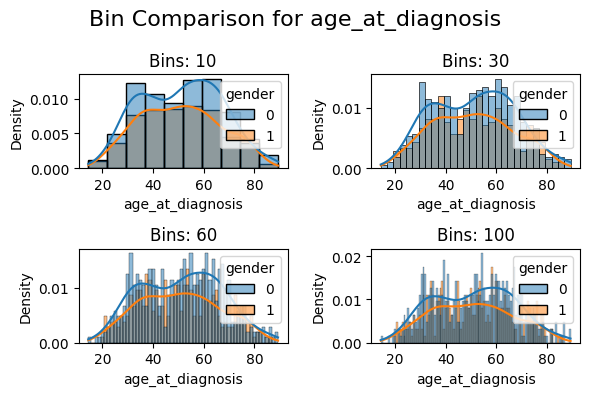

In [8]:
#bringing out a function i did for a project on my own, tweaking to add gender as hue to see of I need to stratify
def bincheck(df, colname, bins=[5, 10, 15, 20]):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 4)) #2x2 plots for 4 bins, making them fairly small so screen does not blow up
    fig.suptitle(f"Bin Comparison for {colname}", fontsize=16)
    
    sns.histplot(df, x=colname, stat="density",hue="gender", bins=bins[0], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title(f"Bins: {bins[0]}") #0th bin
    #histogram with KDE for smoother distribution visualization
    sns.histplot(df, x=colname, stat="density", hue="gender",bins=bins[1], kde=True, ax=axes[0, 1])
    axes[0, 1].set_title(f"Bins: {bins[1]}")

    sns.histplot(df, x=colname, stat="density",hue="gender", bins=bins[2], kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(f"Bins: {bins[2]}")

    sns.histplot(df, x=colname, stat="density", hue="gender",bins=bins[3], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title(f"Bins: {bins[3]}")
    
    plt.tight_layout()
    plt.show()
bins=[10,30,60,100] 

bincheck(df,"age_at_diagnosis", bins)

No difference betwen males and females. Thats good. Bit of a bimodal pattern though. At least 2 models?

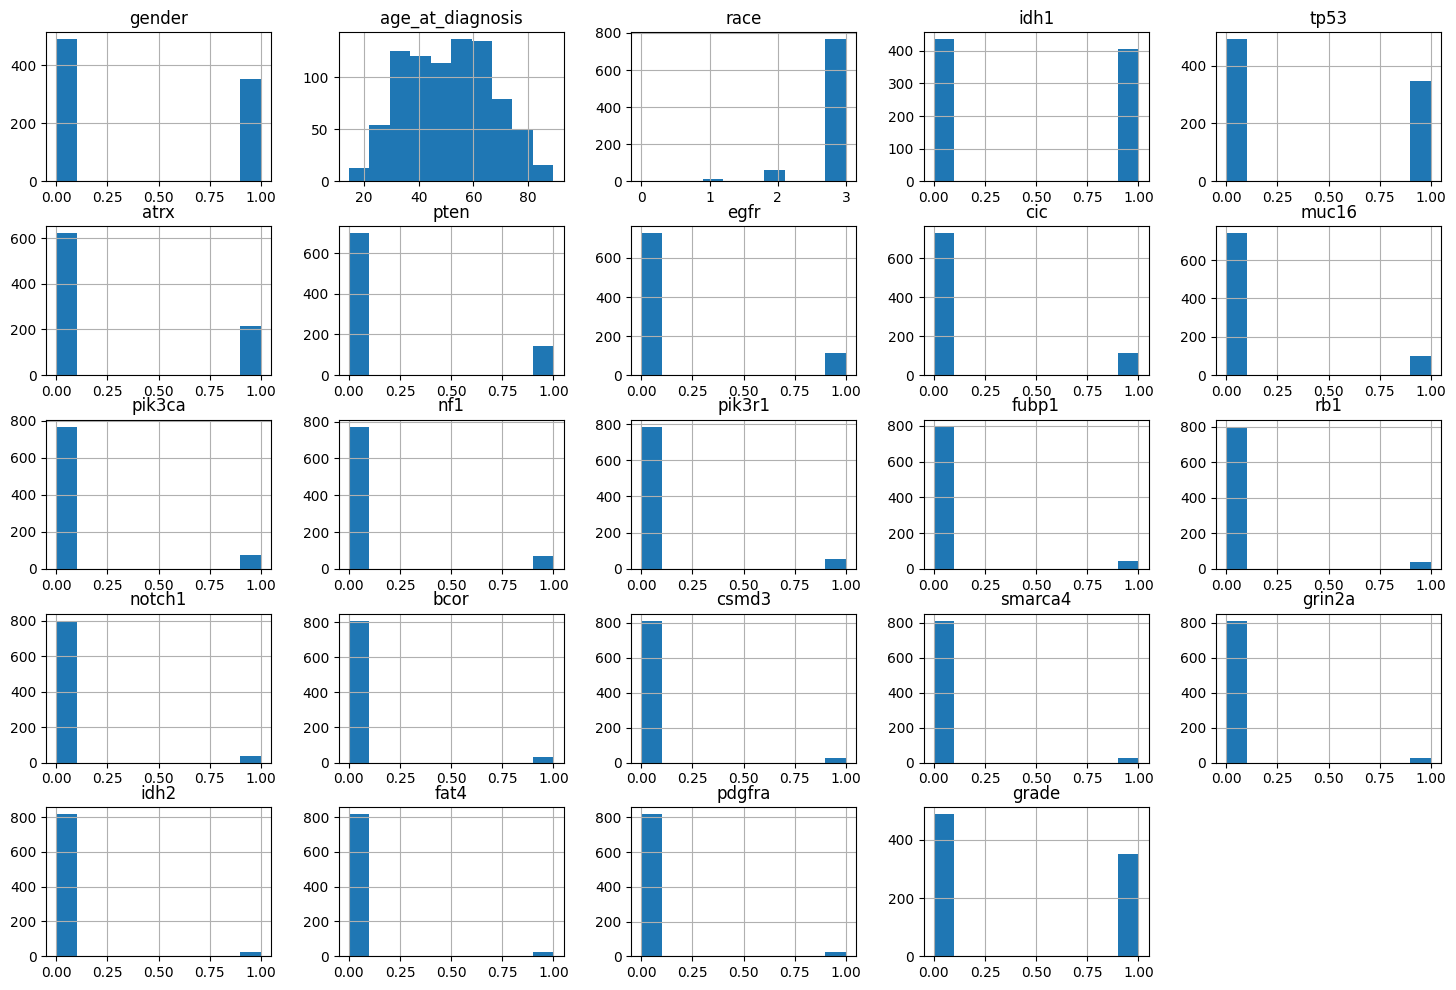

In [9]:
df.hist(figsize=(18, 12)) #checking all the histograms
plt.show()

Thats a lot of binary values. Looking at documentation one can see that its a matter of mutated=1 or not mutated=0.  
And grade = 1 == bad cancer.  
So There is probably some kind of threshold of accumulating mutations one has to pass in order to get a cancer diagnosis.

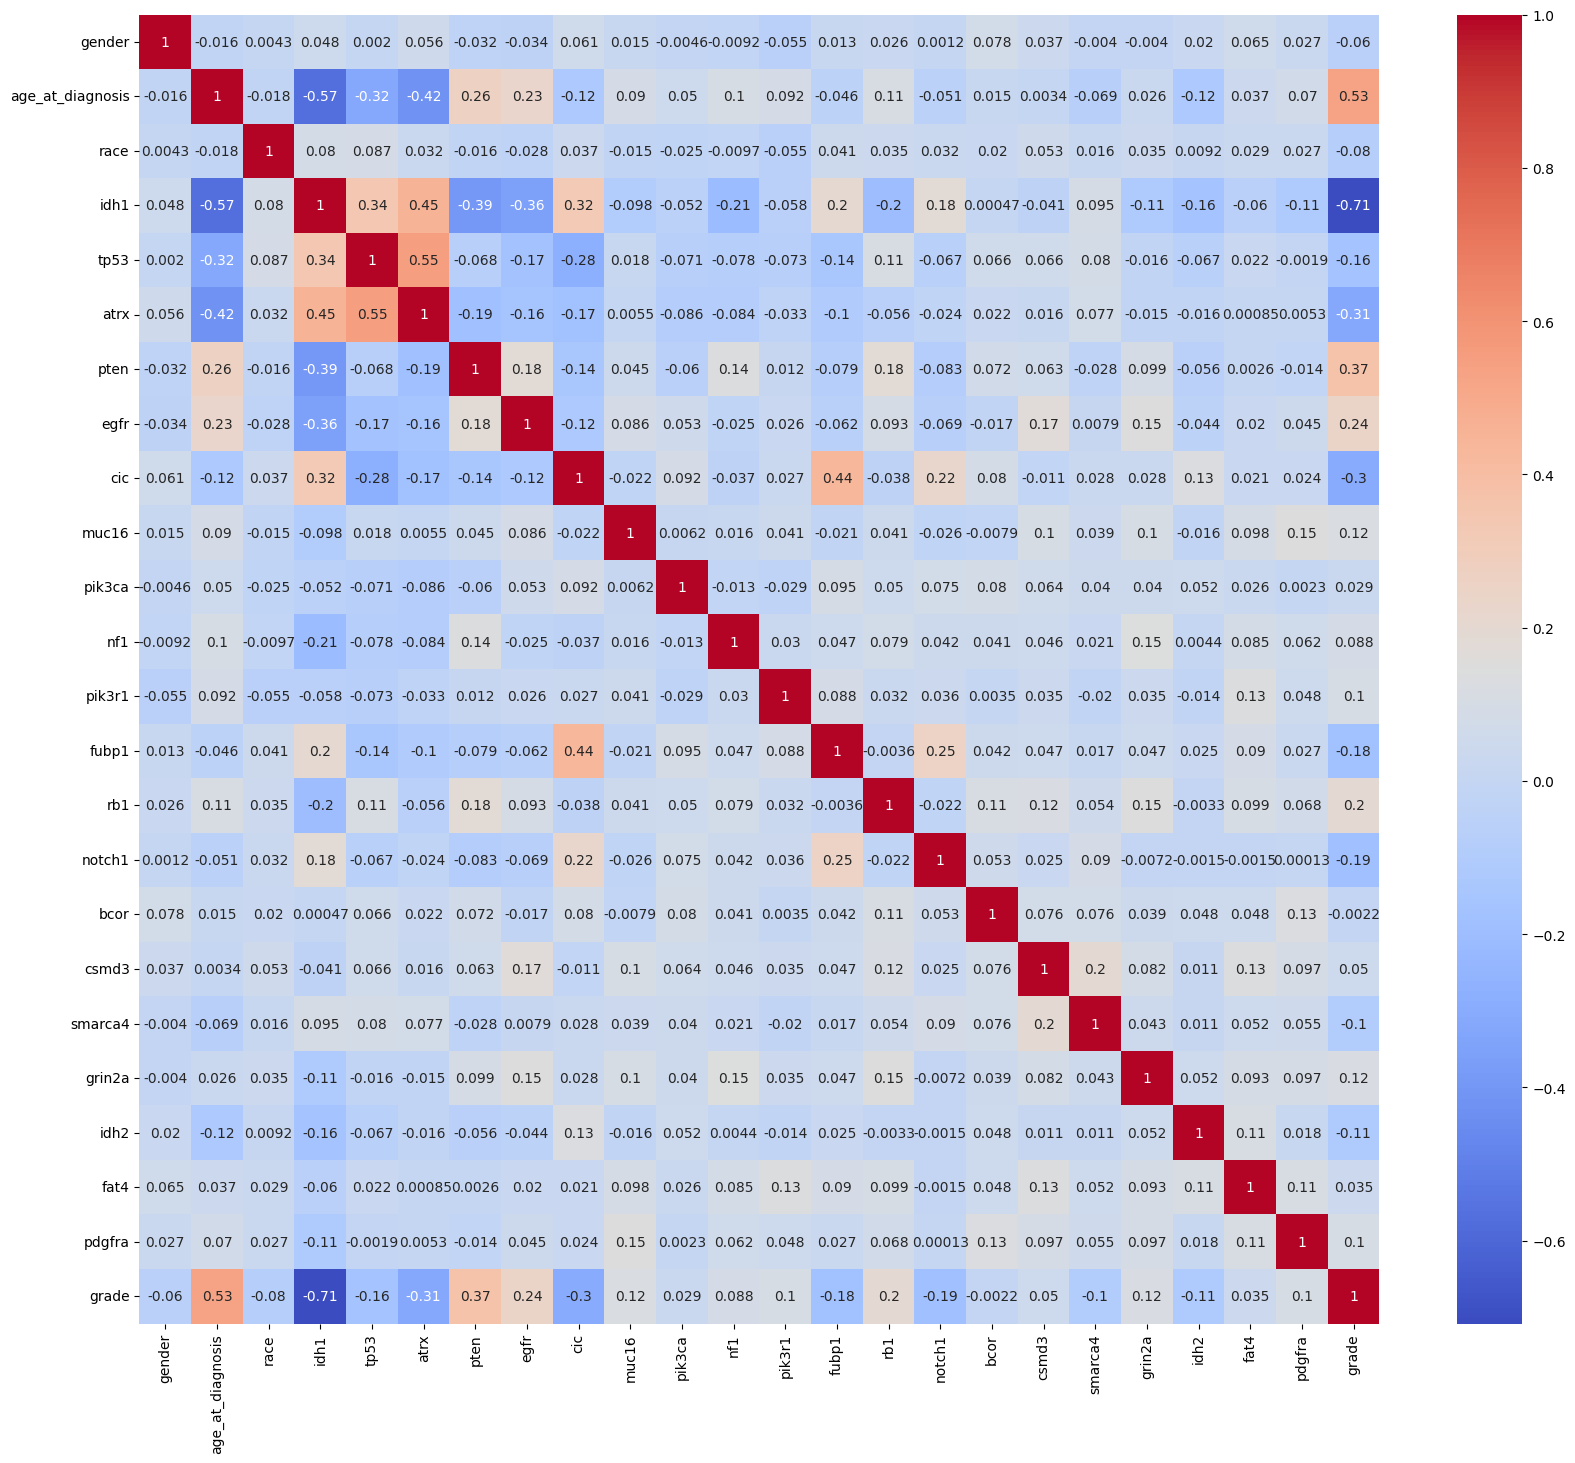

In [10]:
plt.figure(figsize=(20, 17)) #many features big heatmap
sns.heatmap(df.corr(), annot=True, fmt=".2g",cmap="coolwarm") 
#heatmap looks nicer than just a print. "Smart" formatting #grab 2 most important decimals
plt.show()

Age is big positive correlation! Even if it was bimodal on hists.  

Idh1 big negative, atrx is quite big too

In [11]:
age_threshold=50
below50 = df[df["age_at_diagnosis"] <= age_threshold]
above50 = df[df["age_at_diagnosis"] > age_threshold]

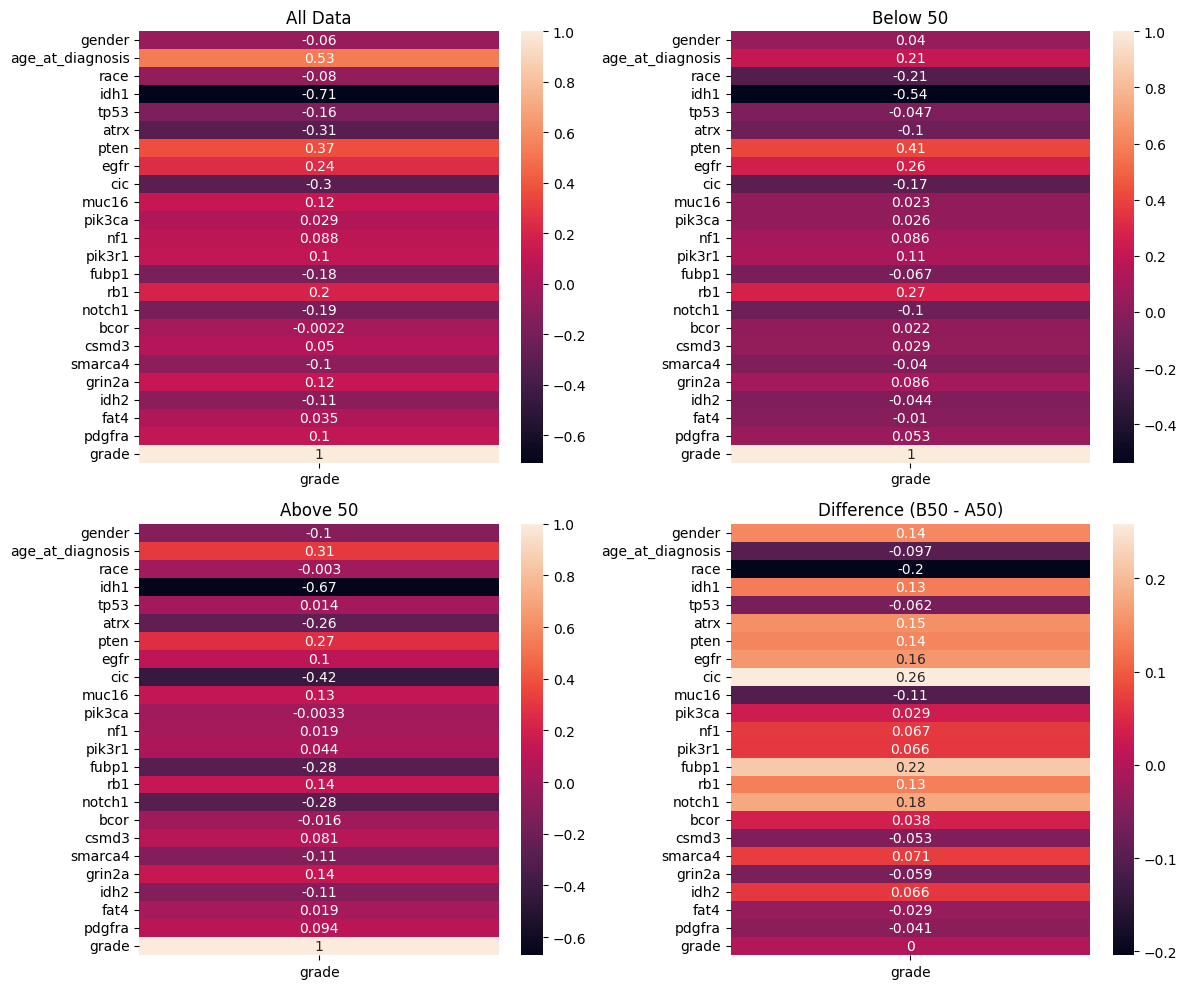

In [12]:
corr_with_target = df.corr()["grade"].to_frame()
b50_corr_with_target = below50.corr()["grade"].to_frame()
a50_corr_with_target = above50.corr()["grade"].to_frame()
diffs = b50_corr_with_target - a50_corr_with_target

# 2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.heatmap(corr_with_target, annot=True, fmt=".2g", ax=axes[0,0])
sns.heatmap(b50_corr_with_target, annot=True, fmt=".2g", ax=axes[0,1])
sns.heatmap(a50_corr_with_target, annot=True, fmt=".2g", ax=axes[1,0])
sns.heatmap(diffs, annot=True, fmt=".2g", ax=axes[1,1])

axes[0,0].set_title("All Data")
axes[0,1].set_title("Below 50")
axes[1,0].set_title("Above 50")
axes[1,1].set_title("Difference (B50 - A50)")

plt.tight_layout()
plt.show()

Small differences but directionally similar. Definitely some kind of nonlinear or piecewise linearity.  
Or some age*feature_n feature engineering if all else fails.  

Just want to sort positive and negative correlations as well out of curiosity.

In [13]:
positive_corr=df.corr()[["grade"]][df.corr() > 0] #create df with negative values filtered
positive_corr=positive_corr.dropna() #drop filtered values
positive_corr=positive_corr.sort_values(by="grade", axis=0, ascending=False) #sorting to see big ones

positive_corr

grade
grade             1.000000
age_at_diagnosis  0.529203
pten              0.367174
egfr              0.241527
rb1               0.195168
muc16             0.119447
grin2a            0.118685
pdgfra            0.102327
pik3r1            0.101813
nf1               0.088123
csmd3             0.050257
fat4              0.034767
pik3ca            0.028905

In [14]:
negative_corr=df.corr()[["grade"]][df.corr() < 0] #create df with positive values filtered
negative_corr=negative_corr.dropna() #drop filtered values
negative_corr=negative_corr.sort_values(by="grade", axis=0, ascending=True)
negative_corr

grade
idh1    -0.708141
atrx    -0.314625
cic     -0.303459
notch1  -0.185175
fubp1   -0.180956
tp53    -0.161786
idh2    -0.113150
smarca4 -0.100286
race    -0.080084
gender  -0.060033
bcor    -0.002206

Maybe one can do a super simple model consisting of sum(positive)-sum(negative) correlations since we are talking binary measurements or maybe top 5 most impactful mutations in each direction.
Ill see how much time I have left once done with basic modelling.

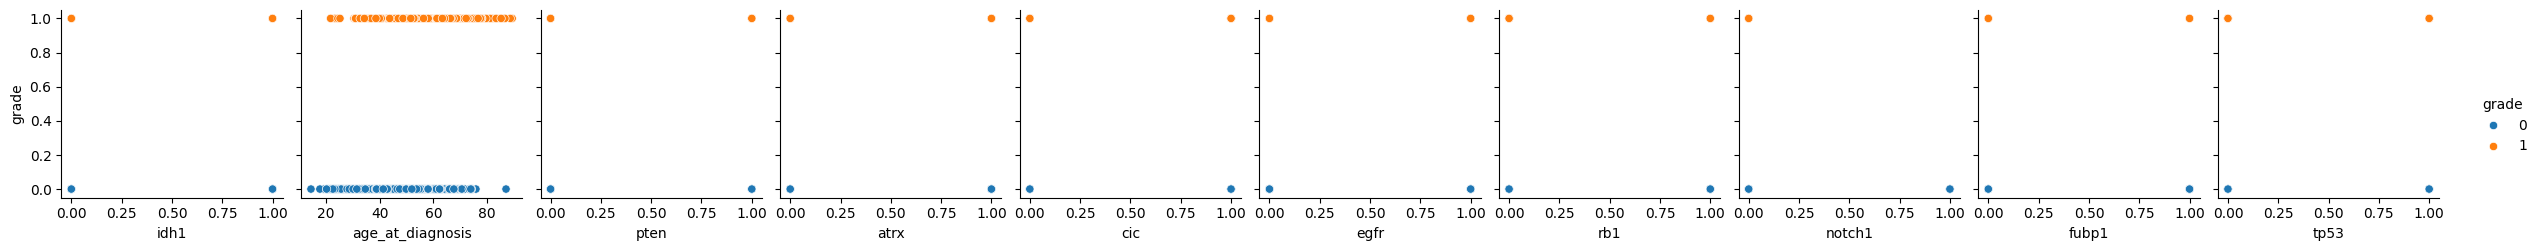

In [15]:
# Making pairplot more readable by grabbing the top corr values with grade
corr_with_target = df.corr()["grade"].abs().sort_values(ascending=False)
top_features = corr_with_target[1:11].index.tolist()  # top 10 excluding grade

# Pairplot only with top correlated features
sns.pairplot(df[top_features + ["grade"]], y_vars="grade", hue="grade", diag_kind="kde")
plt.show()

Well this was pointless. Should have figured by all the categorical data.  
If I had stopped and though for 2 seconds I should have realized that this was pointless.  
Thinking for another 2 seconds. Its only age_at_diagnosis that make sense to run box and regplots on here.  

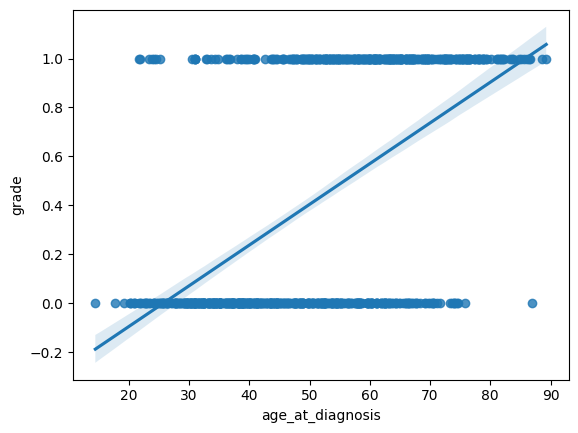

In [16]:
sns.regplot(x="age_at_diagnosis", y="grade", data=df)
plt.show()

Hoping for a log relationship was too much. Falls in line with earlier .corr though. Age matters but isn't causative.  
You simply have more time to accumulate more bad mutations with age.  

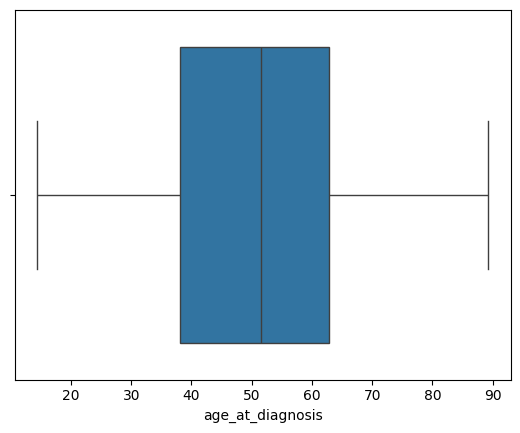

In [17]:
sns.boxplot(x="age_at_diagnosis", data=df)
plt.show()

At least there are no outliers and documentation said no missing data. So no need for removal or cleaning.

<div class='alert alert-block alert-success' style="font-weight:bolder">

## 1.2 Preprocessing

Now that you have a feeling about the data, have a glance over the preprocessing functions and tools available in [Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html). 

Apply as many preprocessing as you like. Some good, first to go choices may be [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler), [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) and so on.

And keep in mind that you can handle some categorical features using preprocessing tools in sklearn with [Encoding categorical features](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features). You can also choose to handle these using pandas, numpy, up to you

You should compare the effect of the different preprocessing steps on the performance of the models you are going to try.


</div>

In [18]:
# a bit weird to do scaling on binary data

maxabs=ColumnTransformer([ 
    ("scaler", MaxAbsScaler(), ["age_at_diagnosis"])], 
    #if data range is negative to positive we get -1,1. If data is only negative -1,0. Pos 0,1
    remainder="passthrough", #skip all other features
    verbose_feature_names_out=False #otherwise colname will be "scaled_colname"
    )
minmax=ColumnTransformer([ 
    ("scaler", MinMaxScaler(), ["age_at_diagnosis"])],
      #All values are scaled to range 0,1
    remainder="passthrough",
    verbose_feature_names_out=False
    )
normal=ColumnTransformer([ 
    ("scaler", Normalizer(), ["age_at_diagnosis"])],  
    #This one scales rows, makes eucledian length of the row = 1, 
    # aka unit vector (sqrt(sq1 +sq2...+sqn)). Probably useless here.
    remainder="passthrough",
    verbose_feature_names_out=False
    )
power=ColumnTransformer([ 
    ("scaler", PowerTransformer(), ["age_at_diagnosis"])], 
    # This is sortof like boxcox (assuming positive values). 
    #Transforms right skewed data towards normal dist. Probably useless too.
    remainder="passthrough",
    verbose_feature_names_out=False
    )
quantile=ColumnTransformer([ 
    ("scaler", QuantileTransformer(), ["age_at_diagnosis"])], 
    #forces outliers into a normal dist [1, 2, 2, 3, 100]->[0.0, 0.25, 0.5, 0.75, 1.0]
    #can change n_quantiles, looks like default is 1000 or n_datapoints. 
    # Seems like its a bit of an overfitting preprocessing risk here. 
    # But ill just leave defaults for now since I dont think preprocessing will make a big diff anyway
    # This is good for making data more linear!!!
    remainder="passthrough",
    verbose_feature_names_out=False

    )
robust=ColumnTransformer([ 
    ("scaler", RobustScaler(), ["age_at_diagnosis"])],
    # Like standardscaler sortof but way less sensitive to outliers since it uses median and IQR
    remainder="passthrough",
    verbose_feature_names_out=False
    )
standard=ColumnTransformer([ 
    ("scaler", StandardScaler(), ["age_at_diagnosis"])], # Z scales
    remainder="passthrough",
    verbose_feature_names_out=False
    )


In [19]:
#Unclear wether to split data or not! But I recon i better do it. 
X = df.drop("grade", axis=1)
Y = df["grade"]

X_train, X_test, Y_train, Y_test =train_test_split(X,Y, test_size=0.2, random_state=42)
display(X.shape,X_train.shape, X_test.shape)
print(X.shape[0] == X_train.shape[0] + X_test.shape[0]) #Double checking because im paranoid

(839, 23)

(671, 23)

(168, 23)

True


In [20]:
#boilerplate mode activated. Making one set of X_train and X_test for each scaler
maxabs.set_output(transform="pandas")
Xtrain_maxabs = maxabs.fit_transform(X_train) 
Xtest_maxabs=maxabs.transform(X_test)

minmax.set_output(transform="pandas")
Xtrain_minmax = minmax.fit_transform(X_train) 
Xtest_minmax=minmax.transform(X_test)

normal.set_output(transform="pandas")
Xtrain_normal = normal.fit_transform(X_train) 
Xtest_normal=normal.transform(X_test)

power.set_output(transform="pandas")
Xtrain_power = power.fit_transform(X_train) 
Xtest_power=power.transform(X_test)

quantile.set_output(transform="pandas")
Xtrain_quantile = quantile.fit_transform(X_train) 
Xtest_quantile=quantile.transform(X_test)

robust.set_output(transform="pandas")
Xtrain_robust = robust.fit_transform(X_train) 
Xtest_robust=robust.transform(X_test)

standard.set_output(transform="pandas")
Xtrain_standard = standard.fit_transform(X_train) 
Xtest_standard=standard.transform(X_test)


/home/carlraask/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (671). n_quantiles is set to n_samples.
  warnings.warn(


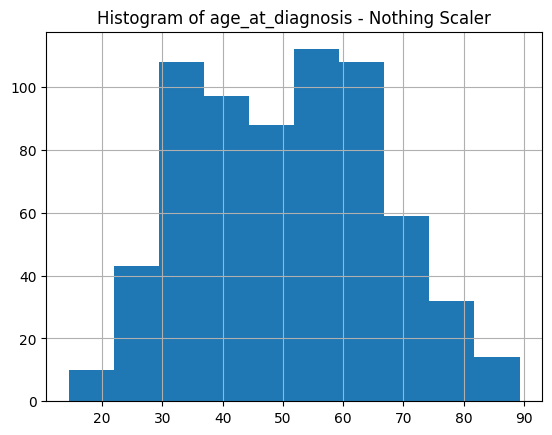

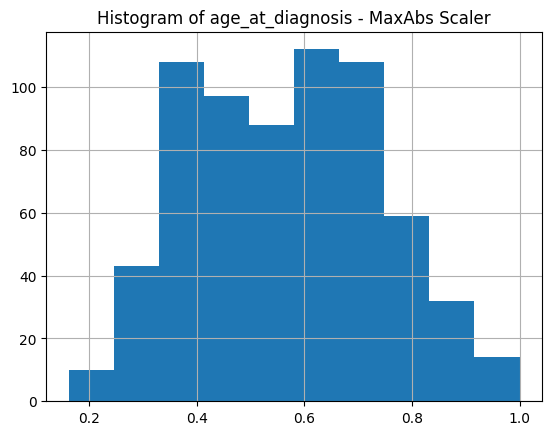

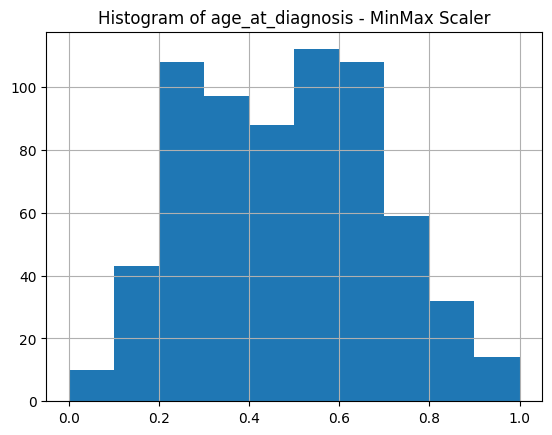

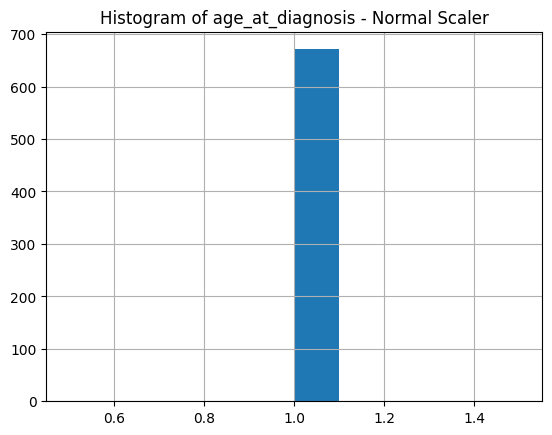

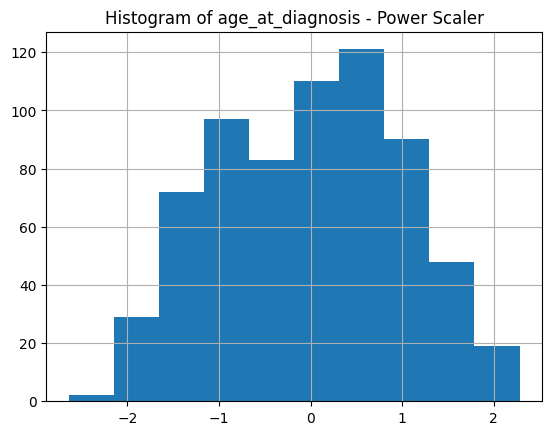

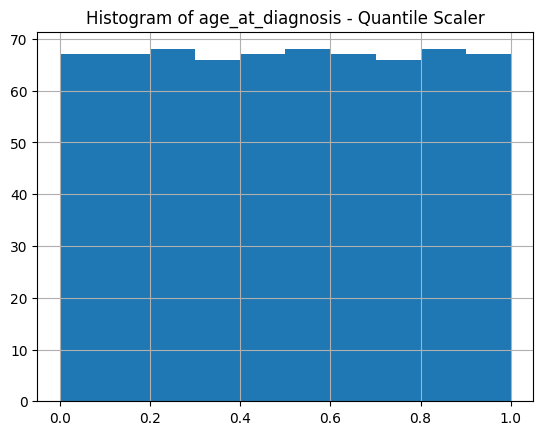

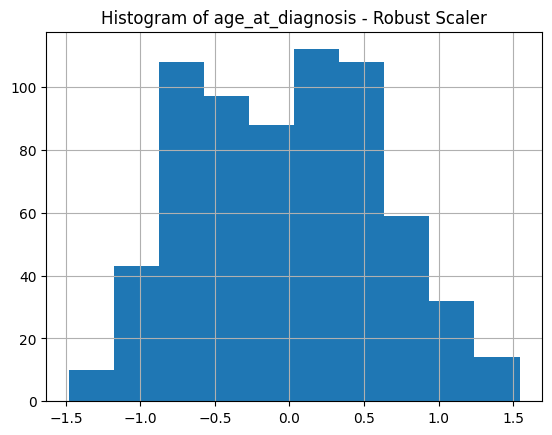

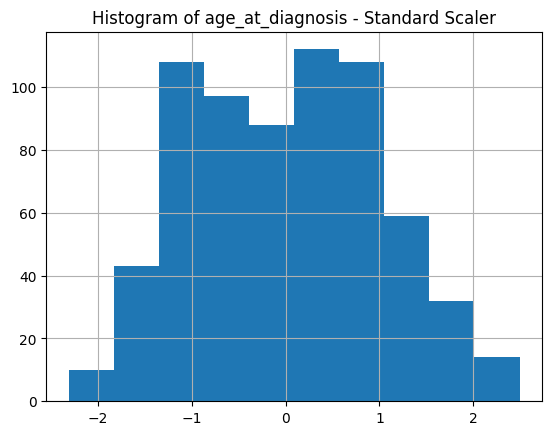

In [21]:
scalers = {
    "Nothing": X_train,
    "MaxAbs": Xtrain_maxabs,
    "MinMax": Xtrain_minmax, 
    "Normal": Xtrain_normal,
    "Power": Xtrain_power,
    "Quantile": Xtrain_quantile,
    "Robust": Xtrain_robust,
    "Standard": Xtrain_standard
}

for name, sc_df in scalers.items(): #one hist for each scaler Train set
    plt.figure()
    sc_df["age_at_diagnosis"].hist()
    plt.title(f"Histogram of age_at_diagnosis - {name} Scaler")
    plt.show()

Quantile and normal scalers were the only ones really making a change.  
I think normal would be very different if I applied it on a df full of continuous values.  
Quantile scaler seem like a great way to do feature engineering if pairplot y_vars=target show a bunch of nonlinear relationships though  
Would have loved to try this stuff with more continuous data  

<div class='alert alert-block alert-success' style="font-weight:bolder">


## 1.3 Estimators

Please have a look at [Supervised learning](https://scikit-learn.org/stable/supervised_learning.html) section and find the list of available, out of the box models ready to use.

Feel free to choose any of them you like. I would suggest to use the classification models you may be familiar with, like [Nearest Neighbors Classification](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification), [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html), [Decision Trees](https://scikit-learn.org/stable/modules/tree.html#classification), ... .

In the meanwhile there is no reason to hold yourself back from try models that are new for you.

You are highly recomended to use [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) to connect the preprocessing steps and estimators.

</div>

In [22]:
#going to test wich scaler is best on a simple logreg, 

for name in scalers.keys(): #walk through all scalers
    sctrain = scalers[name]

    
    clf=LogisticRegression(random_state=42) #Ever powerful random_state=42
    clf.fit(sctrain, Y_train) #fit on train
    
    #predict both train and test (even if test technically should be holdout since we are running kfold later)
    clf_pred_train=clf.predict(sctrain)


    #confusion matrices for easy overview
    train_cm=confusion_matrix(Y_train, clf_pred_train)



    print(name)
    print(train_cm)
    print("correct clf:", train_cm[0][0]+train_cm[1][1]) #sum of diagonals for quick and dirty comparison on "acc"
    print("************")
    

Nothing
[[342  56]
 [ 25 248]]
correct clf: 590
************
MaxAbs
[[339  59]
 [ 21 252]]
correct clf: 591
************
MinMax
[[339  59]
 [ 21 252]]
correct clf: 591
************
Normal
[[336  62]
 [ 20 253]]
correct clf: 589
************
Power
[[342  56]
 [ 23 250]]
correct clf: 592
************
Quantile
[[341  57]
 [ 22 251]]
correct clf: 592
************
Robust
[[342  56]
 [ 24 249]]
correct clf: 591
************
Standard
[[342  56]
 [ 25 248]]
correct clf: 590
************


/home/carlraask/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Changes between scalers is so small that I think its more or less noise.  
I kinda want to do unscaled for simplicity and interpretability  
But I expect that to mess upp distance based classifiers such as knn so Ill just standardscale.  


<div class='alert alert-block alert-success' style="font-weight:bolder">

# Combined 1.3, 1.4 and 1.5

</div>

### Initial Model list  
Logreg for inclusion penalty=["l1", "l2"], C=[0.001,0.01, 0.1,1]  
SVM vanilla and poly.C=[0.001,0.01, 0.1,1] degree=[2,3,4] Might get some age-mutation interactions   
KNN. Lets do both Eucledian and Manhattan for fun. n_neighbours=[5,9,13]   
Vanilla Tree. max_depth=[5,10,15] numbers taken from thin air  
Random Forest max_depth=[5,10,15] numbers taken from thin air  
GBoost learning_rate=[0.001,0.01, 0.1,1]  

PassiveAgressiveClassifier. This has to be included in any swedish ML program (no effect on correct predictions, heavy punishment on errors)  
Gaussian Naive Bayes. No idea what this does! Id guess its some kind of bayesian calculation, funfun


In [23]:
# Only run on university campus to save on electricity bill!!
# NOTE There is a long markdown cell on grid search skeleton code near the end of this notebook "Grid search skeleton code".
# Didnt want to have it in the "assignment" part of the code as it would break the flow.
models_dict = {"logreg": {
                    "model": LogisticRegression(random_state=42),
                    "params": {
                        "penalty" : ["l2"], #changed my mind lbfgs solver only supports l2. I might do a separate l1 later
                        "C" : [0.001,0.01, 0.1,1,10,100] #100 is standin for no regularization to save some warning printouts
                        #could change max_iter but i think lbfgs will stop at a good time regardless on this small dataset
                    },  
                },
                "SVC": {
                    "model" : SVC(kernel="poly",),
                    "params" : {
                        "degree": [1,2,3,4], #degree =1 so i dont have to write out a whole separate dict for linear svc
                        "C":[0.001,0.01, 0.1,1,10,100] #Why do we have differently working Cs on both logreg and SVC?
                    }
                },
                "KNN":{
                    "model": KNeighborsClassifier(),
                    "params":{
                        "n_neighbors": [5,9,13,17,21], 
                        #increased this as I tested the buildout of this megaGS since more neighbours kept improving performance
                        "metric": ["l1", "l2"]
                    }
                },
                "Tree":{
                    "model": DecisionTreeClassifier(random_state=42),
                    "params":{
                        "max_depth":[5,10,15, None]
                    }
                },
                "Forest":{
                    "model": RandomForestClassifier(random_state=42),
                    "params": {
                        "n_estimators": [100, 300, 500], #number of trees
                        "max_depth": [5,10,15, None], #same depth as normal tree
                        "min_samples_split": [2, 5, 10], #overfitting protection
                        "min_samples_leaf": [1, 2, 4],
                    }
                },
                "GBoost":{
                    "model": GradientBoostingClassifier(random_state=42),
                    "params": {
                        "n_estimators": [100, 300, 500], #number of trees
                        "learning_rate": [0.01, 0.05, 0.1], #how much each tree adds to the total prediction
                        "max_depth": [2, 3, 4], #"Weak learners"
                        "min_samples_split": [2, 5, 10], #overfitting protection
                        "min_samples_leaf": [1, 2, 4],
                        "max_features": ["sqrt", "log2", None], #"T"he number of features to consider when looking for the best split" regularization ish
                        #Basicly forcing each tree to specialize in different features
                    }
                },
                #NOTE Had to learn what this CLF does, See "Passive Agressive Nutshell" below for notes
                "PassiveAgressive":{
                    "model" :PassiveAggressiveClassifier(random_state=42), 
                    "params":{
                        "loss" : ["hinge", "squared_hinge"], #not 100% what these do, just testing for now
                        #squared hinge seems to punish mistakes and outliers more. But there are no outliers in this dataset 
                        # so it is probably not useful here
                        "C": [0.001,0.01, 0.1,1,10,100] #remember "inverse l2" here compared to logreg                 
                        }
                        #Small C=more regularization same way SVM does  
                },
                #NOTE I had to learn NBayes x2. See "Naive Bayes...in a nutshell" below for notes
                # Based on notes I should add a normal Naive Bayes rather than Gaussian to the mix!
                "Gaussian NBayes":{
                    "model": GaussianNB(),
                    "params": {
                        "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]  # Only one parameter!
        }               #Makes curves wider. I asked an LLM for help here as I have no idea what reasonable numbers are
    },
                  "Vanilla NBayes":{
                    "model": BernoulliNB(),
                    "params": {
                        #LLM assistance here since I have no prior knowledge of this method
                        "alpha": [0.1, 0.5, 1.0, 2.0], # protects from dividing by 0 by adding alpha in both num and denom calculattion
                        # Always keeps internal relationship for a given class. Affects numerator way more than denom-
                        # Small alpha= small numerator = small L becomes smaller ==
                        # Small alhpa = low bias high variance 
                        #"binarize": [40,50,60,70]  
                        # Makes continious data "discrete" by binning like a 2 bin histogram
                        # This is literally perfect since age was slighly bimodal during eda. I Vote 40 will be best.
                        # NOTE  from the future. Removing binarize fixed NBayes (see extra cells at "Testing the age split") 
                        # but its still the worst model so nothing changes 
                        # Meaning my hunch was waay off. The remaining bad performance might be due to 3 categories in "race" 
                        # (why do americans insist on using the word "race"?)
                        # NOTE 2: I did a manual age cut at 40 in the extra debugging cells at the botom
                        # that cut added ~2% recall compared to whatever is done automaticly here
        }
            }
    }
all_results = []

for model_name, config in models_dict.items():
    gs=GridSearchCV(
        estimator=config["model"], #Work through every model
        param_grid=config["params"], #Test each param of each model
        cv=5, # 80/20 train/test split repeated 5 times
        scoring="recall", #Sensitivity since we generally want to capture all potential cancer cases. 
        #I recon this is not a population screen where false positives are a problem
        n_jobs=-1, #run as much as possible in paralell
        verbose=0 #dont want any progress readouts 
    )
    gs.fit(Xtrain_standard, Y_train)

    all_results.append({
        "name": model_name, #store the best parameters for each model
        "estimator": gs.best_estimator_,
        "score": gs.best_score_,
        "params": gs.best_params_,
        #Storing each fold score and std for later statistical rigour
        "cv_scores": [gs.cv_results_[f"split{i}_test_score"][gs.best_index_] for i in range(5)],  
        "std": gs.cv_results_["std_test_score"][gs.best_index_] #TODO
    })

top_n = 10 # want to compare all of them
top_models = sorted(all_results, key=lambda x: x["score"], reverse=True)[:top_n] #sorts all models based on scoring


print("Top models:")
for i, model in enumerate(top_models, 1):
    print(f'{i}. {model["name"]}: {model["score"]:.4f}, {model["params"]}')

Top models:
1. Gaussian NBayes: 0.9487, {'var_smoothing': 1e-09}
2. SVC: 0.9413, {'C': 1, 'degree': 3}
3. PassiveAgressive: 0.9304, {'C': 0.001, 'loss': 'hinge'}
4. Tree: 0.9268, {'max_depth': 5}
5. GBoost: 0.9268, {'learning_rate': 0.01, 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
6. Forest: 0.9120, {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
7. logreg: 0.9047, {'C': 1, 'penalty': 'l2'}
8. KNN: 0.9046, {'metric': 'l1', 'n_neighbors': 17}
9. Vanilla NBayes: 0.8864, {'alpha': 0.1}


Interesting that Gaussian NBayes performed best. I would have thought it would do terrible, given the binary features.  
Maybe age made such a difference?  
Not too surprised that SVC and PassiveAgressive performed similarly since they are both Margin Maximizers  
Another surprise is that a single Tree won over both GBoost and Random Forest. Maybe I should add more parameters in the gridsearch if I really want to push them another notch.  

Logreg and KNN being at the bottom seems reasonable given that they are such simple models. However given the fact that explainability is an important metric I would still consider using them in a real model since a 5 split tree can be explained, odds are the best slopes of logreg will have some overlap. Shame L1 didn't win though, that would have been better for explainability.

I think vanilla NBayes failed because it binned too hard and I should manually pd.cut(df["age_at_diagnosis]) and play around outside the gridsearch  
But I feel Im on my way to go overboard as is so Ill hold off for now.  
Bit if a shame because I think Vanilla NBayes makes more sense rather than gaussian.  
I don't know why it performed so well on what is mostly binary data.

In [24]:
#statistical rigour
threshold=0.05 # 0.05 because Fisher said it's convenient. Way too high for medical though.

performing_models=top_models[:-1] #removing nbayes for readability

#paired ttest since it is kfold performance "compare models with different conditions"
t_stat, p_value = ttest_rel(performing_models[0]["cv_scores"], 
                             performing_models[1]["cv_scores"])

for i in range(len(performing_models)):
    for j in range(i+1, len(performing_models)):
        _, p = ttest_rel(performing_models[i]["cv_scores"],  
                        performing_models[j]["cv_scores"])
        print(f'{performing_models[i]["name"]} vs {performing_models[j]["name"]}: p={p:.4f} Significant? {p<threshold}')

Gaussian NBayes vs SVC: p=0.1778 Significant? False
Gaussian NBayes vs PassiveAgressive: p=0.0337 Significant? True
Gaussian NBayes vs Tree: p=0.2822 Significant? False
Gaussian NBayes vs GBoost: p=0.0322 Significant? True
Gaussian NBayes vs Forest: p=0.0034 Significant? True
Gaussian NBayes vs logreg: p=0.0039 Significant? True
Gaussian NBayes vs KNN: p=0.0096 Significant? True
SVC vs PassiveAgressive: p=0.0705 Significant? False
SVC vs Tree: p=0.4954 Significant? False
SVC vs GBoost: p=0.0993 Significant? False
SVC vs Forest: p=0.0168 Significant? True
SVC vs logreg: p=0.0111 Significant? True
SVC vs KNN: p=0.0226 Significant? True
PassiveAgressive vs Tree: p=0.8541 Significant? False
PassiveAgressive vs GBoost: p=0.3739 Significant? False
PassiveAgressive vs Forest: p=0.1430 Significant? False
PassiveAgressive vs logreg: p=0.0524 Significant? False
PassiveAgressive vs KNN: p=0.1097 Significant? False
Tree vs GBoost: p=1.0000 Significant? False
Tree vs Forest: p=0.4716 Significant? F

In general there is no significant difference within between models that output sensitivity scores in close range to each other.  
However there is clear differentiation between top 3 performers and bottom performers so if anything I think the Tree would be the best model. 
2.5% worse than Gaussian Nbayes but no significant difference and much easier explainability considering its a max_depth=5 compared to a 3rd degree polynomial that **probably** is reinforcing the age == more mutations relation.

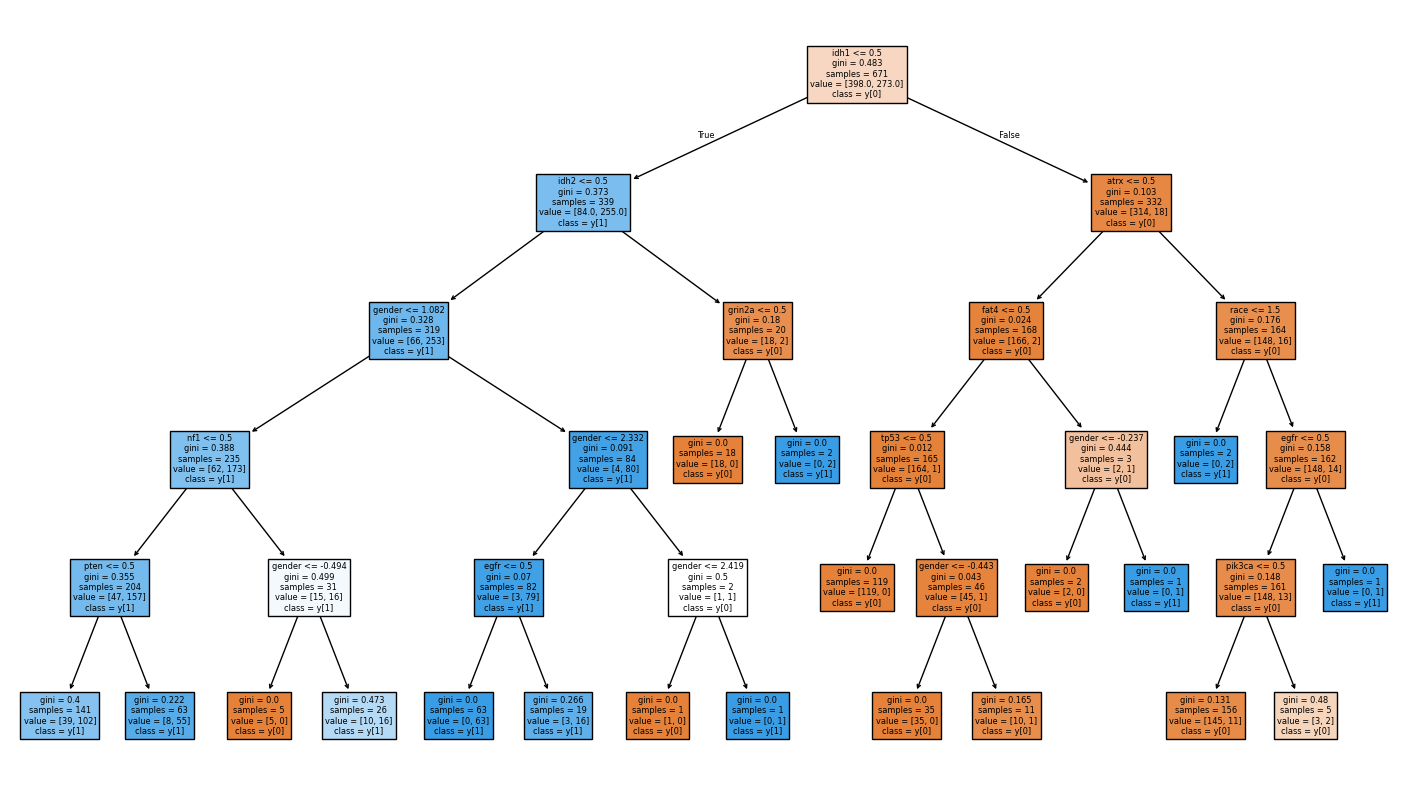

In [25]:
plt.figure(figsize=(18, 10))

tree.plot_tree(performing_models[3]["estimator"],
               feature_names=list(X.columns[:-1]),
               class_names=True,
               filled=True)
plt.show()

In [26]:
# Significance testing on first split

# NOTE I had to learn how to do Chi2 and how it worked. See notes under "Chi² in a nutshell"

# split the dataframe
threshold1 = 0.5 #I could do any value higher than 0 and lower than 1 but it feels best with 0.5
below1 = df[df["idh1"] <= threshold1]
above1 = df[df["idh1"] > threshold1]

# build contingency table
contingency = pd.crosstab(
    df["grade"],  # rows = grade categories
    df["idh1"] > threshold1  # columns = True/False (above/below threshold)
)

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Number of patients without idh1: {len(below1)}")
print(f"Number of patients with idh1: {len(above1)}")
print()
print(f"Chi-square statistic: {chi2:.5f}")
print(f"p-value: {p:.10f}")
print(f"Degrees of freedom: {dof}")
print("Expected counts:")
print(expected)


Number of patients without idh1: 435
Number of patients with idh1: 404

Chi-square statistic: 417.86079
p-value: 0.0000000000
Degrees of freedom: 1
Expected counts:
[[252.49702026 234.50297974]
 [182.50297974 169.49702026]]


Hah! Idh1 who had the largest absolute correlation (negative) with grade also is the root node.  
If you don't have the mutation you go to the false split which contains way more diagnosis leaves. 
Thats all we need to know.   
Lets send this to the gene therapists ASAP.  


## Conclusion  and validation
I think Decision tree would be the best model to use for this particular task.  
Based on the combination of small difference in performance between the best models,  
lack of significant difference between them and the fact that a decision tree is reasonably explainable to at least a doctor.

In [27]:
best_model = performing_models[3]["estimator"] #Idx 3 = Decision Tree

best_model.fit(X_train, Y_train) #I dont even have to think about scaling for trees!!

best_test_pred=best_model.predict(X_train)

best_pred=best_model.predict(X_test)


sensitivity_train=recall_score(Y_train, best_test_pred)
sensitivity_test=recall_score(Y_test, best_pred)
print("Sensitivity scores train/test: ",sensitivity_train ,sensitivity_test)

Sensitivity scores train/test:  0.9487179487179487 0.9240506329113924


Pretty good generalization for such a small dataset as well. 
I think this is as good as it gets. 

<div class='alert alert-block alert-danger' style="font-weight:bolder">

### Second guessing myself!

After thinking a bit...   
I realized i had started EDA and stuff before train test splitting!   
Have to check if i accidentally had some data leakage.  
</div>

In [28]:
#rebuilding a df from train data so i can get a new corr
train_df = X_train.copy()
train_df["grade"] = Y_train
train_corrs=train_df.corr()

all_corrs=df.corr() #could have reused old corr matrix but oh well

tols=[1,0.1,0.01,0.001,0.0001]
for t in tols:
    print("Threshold: ",t,np.allclose(train_corrs, all_corrs, atol=t))
    #checking to see if all values are close to another at different tresholds

idh1_diff = abs(train_corrs["idh1"]["grade"] - all_corrs["idh1"]["grade"])
print(f"IDH1 correlation absolute difference between all and train: {idh1_diff:.4f}")

Threshold:  1 True
Threshold:  0.1 True
Threshold:  0.01 False
Threshold:  0.001 False
Threshold:  0.0001 False
IDH1 correlation absolute difference between all and train: 0.0023


Those differences should be negligible and be within generalization territory.  
But as a side note. Being handed a notebook with df.describe() etc already prewritten made me go into EDA mode before considering leakage.  
Perhaps consider adding a train_test split before .describe next iteration of this lab?

<div class='alert alert-block alert-success' style="font-weight:bolder">

# Lab 2: SHAP
The main requirement from you is your comments and explanations.  
Feel free to use other plotting techniques and tools provided in the shap library.  

Tasks:  
1- Data Preparation and Model Training:  
·               Revisit the healthcare dataset used in the previous assignment.  
Perform any necessary data preprocessing (scaling, encoding, etc.).  
Train at least two different machine learning models on the dataset (e.g., logistic regression, random forest).  
**You are advised to keep the code from the previous assignment**  
 
2- Basic SHAP Analysis:  
·               Install and import the SHAP library.  
Use SHAP to explain individual predictions for each model.  
Visualize the SHAP values for a few sample predictions.  

3- Feature Importance Analysis:  
·               Generate SHAP summary plots to understand the most influential features for each model.  
Compare the feature importance across different models.  
Discuss any differences in feature importance and what they might imply about each model.  
Create SHAP dependence plots to visualize the effect of a single feature across the entire dataset.  
 
4- Model Comparison and Insights:  
·               Compare the interpretability of the different models using SHAP.  
Discuss how SHAP insights can aid in practical healthcare decision-making.  
Reflect on any limitations or challenges encountered while using SHAP.  
</div>

## Decision tree shap

### Individual shap

In [29]:

#Explainer sets up the shapley equation but leaves empty slots for specific observation values
tree_explainer= shap.TreeExplainer(best_model, 
                                   model_output="raw") #log odds!

#grab sample data according to lab instructions
X100 = shap.utils.sample(X_train, #I guess one should pick validate or holdout or even new observations here?
                         100, #Select 100/~800 observations
                         random_state=42) #tutorial missed random state! I want consistency
#shap.utils.sample is more or less a fancy np.random.choice(replacement=False) 
# but uses stratified sampling to cover original distribution better    

shap_tree_vals=tree_explainer(X100) #Run the randomly selected variables thoguh the shapley equation and store them

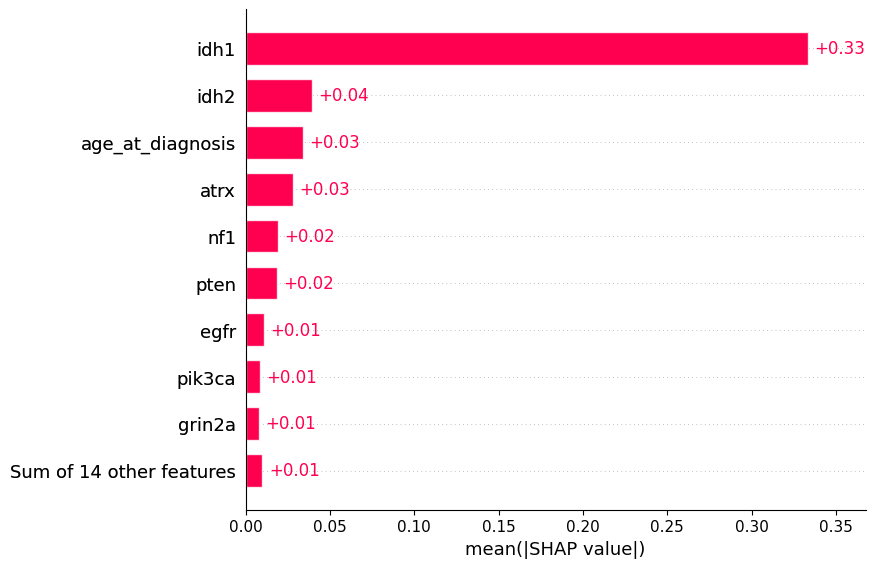

In [30]:
shap.plots.bar(shap_tree_vals[:, :, 1]) 
# (shap_tree_vals[:, :, 1]) #need this list slicing for specifying wich class we are going for


shap.plot.bar displays:  
Abs mean of all values meaning that a big bar might consist of big negative + big positive values  
This is kinda useless in my opinion since all we see is feature impact magnitude but not direction,  
given the fact that it takes about as much typing and rendering for a .waterfall as a .bar.  

Predicting class:  1


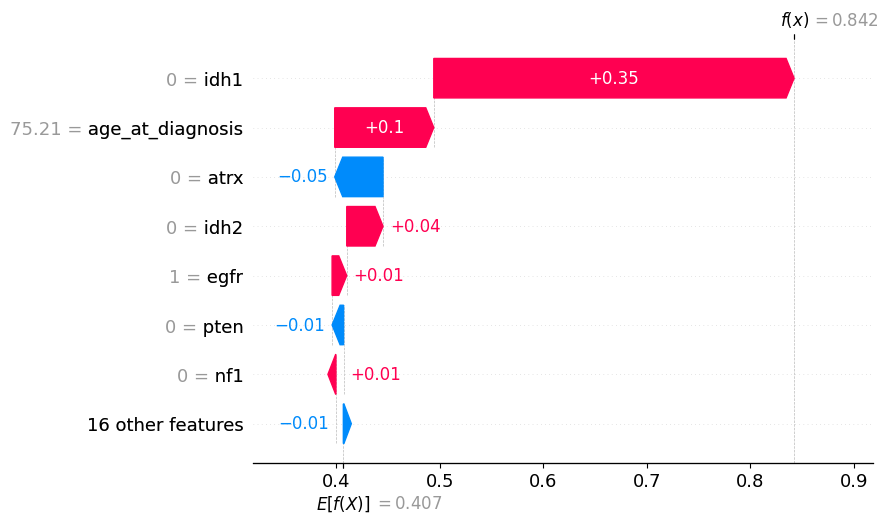

In [31]:
single_obs = X_train.iloc[[42]]  # One might as well grab an observation from the dataframe rather than relying on stochasticity
pred_class=best_model.predict(single_obs)[0]
print("Predicting class: ",pred_class)
shap.plots.waterfall(tree_explainer(single_obs)[0, :, pred_class], max_display=8) #pred_class to specify what direction we are looking at
#this was not included in tutorial lecture code as API has been updated. 

In this specific instance the big one is the fact that the observation has no idh1 mutation (idh1=0).  
And as seen in .corr earlier having this mutation is highly negatively correlated with having a grade=1

Idh1 singlehandedly accounts for .35 log odds of models prediction.  
Baseline is  0.407 log odds so idh1 alone would push us to 0.75 log odds.
I would assume that since idh1 accounts for so much of the prediction that the other features doesn't really matter.   

See "Treeshap" notes to see reasons for below code.  
Warning for wall of output.  

12 unique leaves in sample
plot_tree has 12 leaves so this is promising. Decent sign X100 is a representative sample
Path to prediction for index no in X100:  0
Predicted class:  1


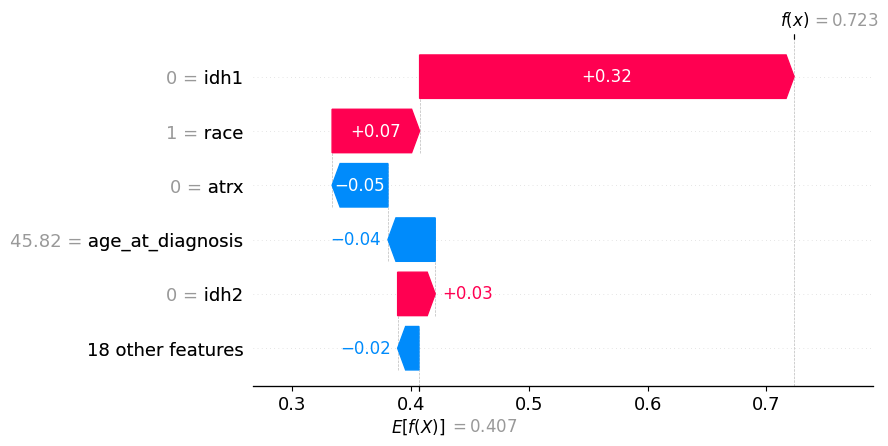

Path to prediction for index no in X100:  2
Predicted class:  1


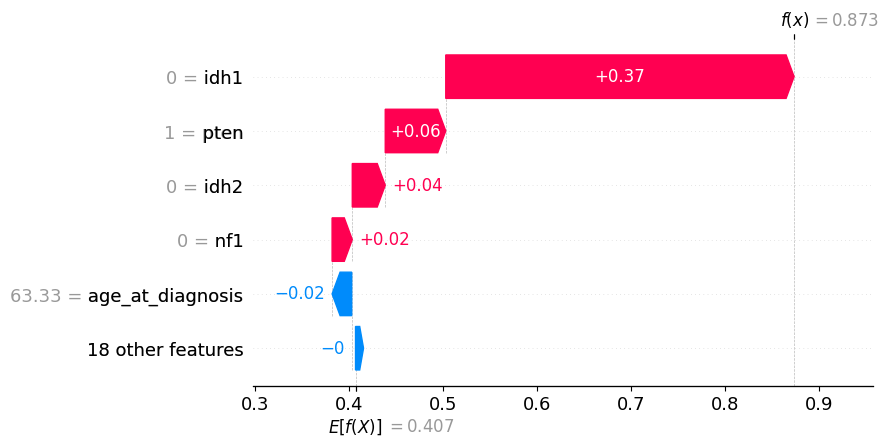

Path to prediction for index no in X100:  59
Predicted class:  0


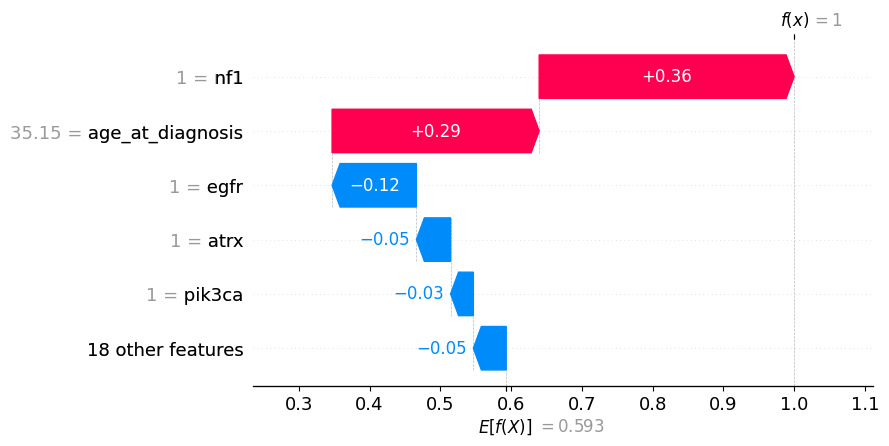

Path to prediction for index no in X100:  21
Predicted class:  1


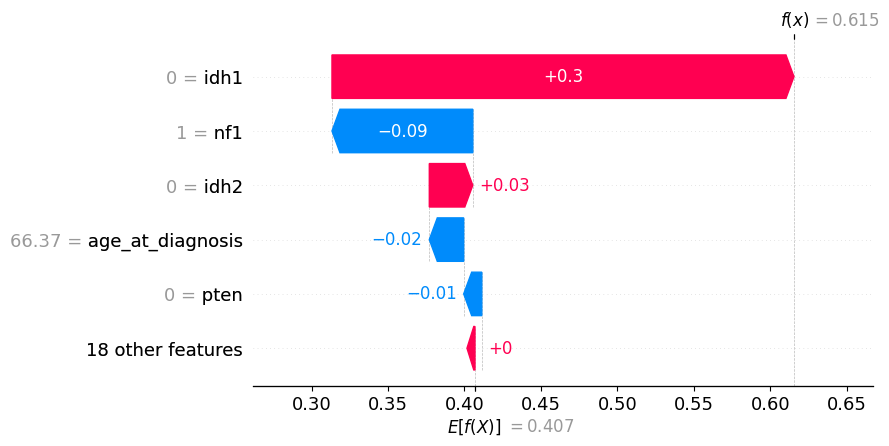

Path to prediction for index no in X100:  33
Predicted class:  1


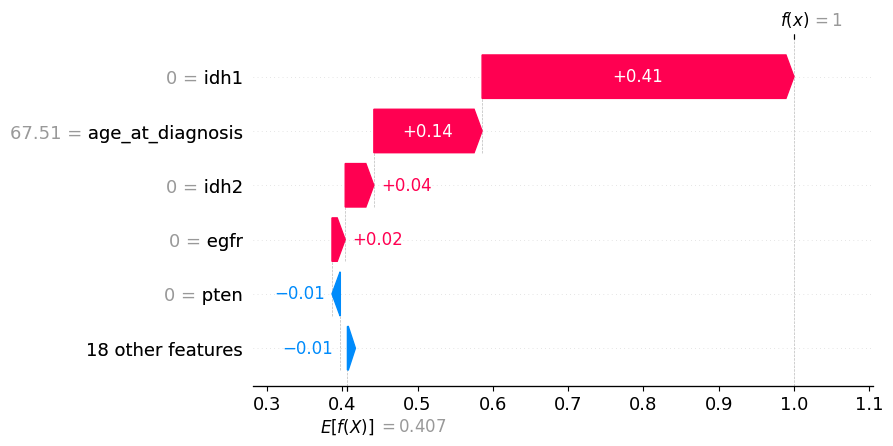

Path to prediction for index no in X100:  87
Predicted class:  1


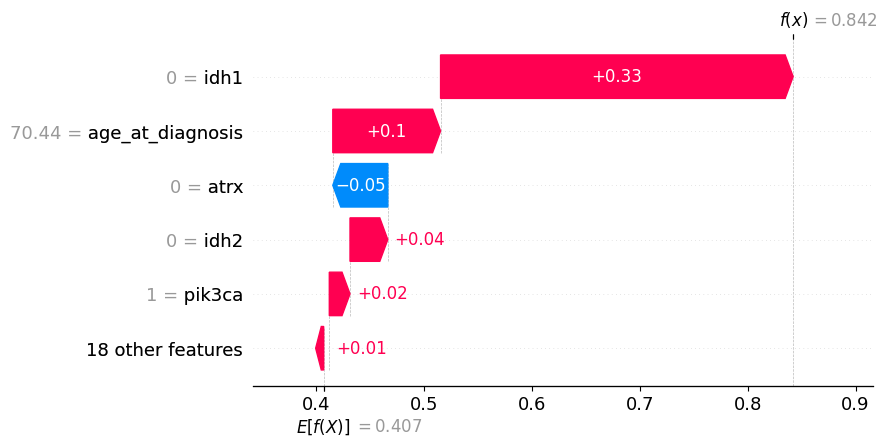

Path to prediction for index no in X100:  6
Predicted class:  0


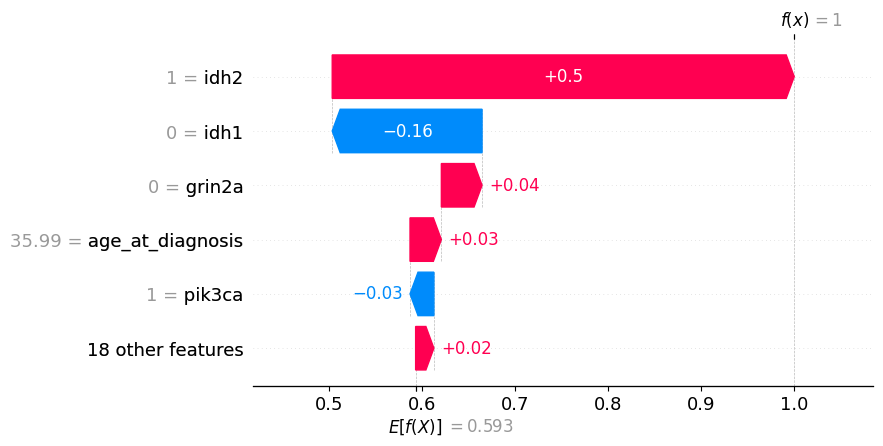

Path to prediction for index no in X100:  46
Predicted class:  1


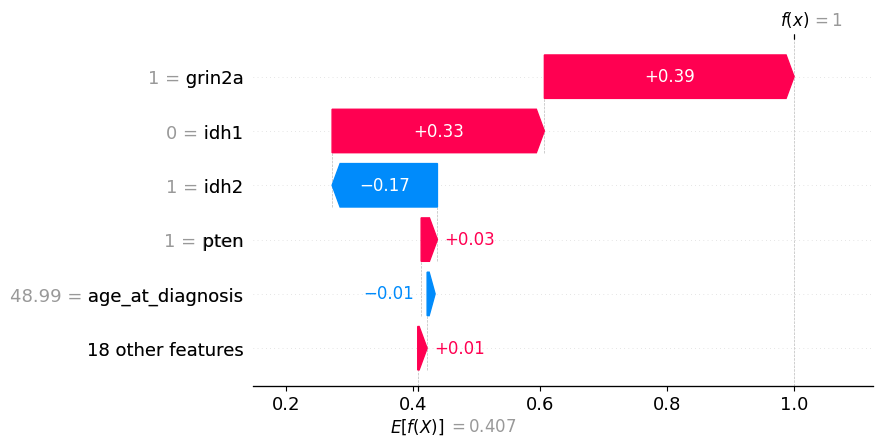

Path to prediction for index no in X100:  13
Predicted class:  0


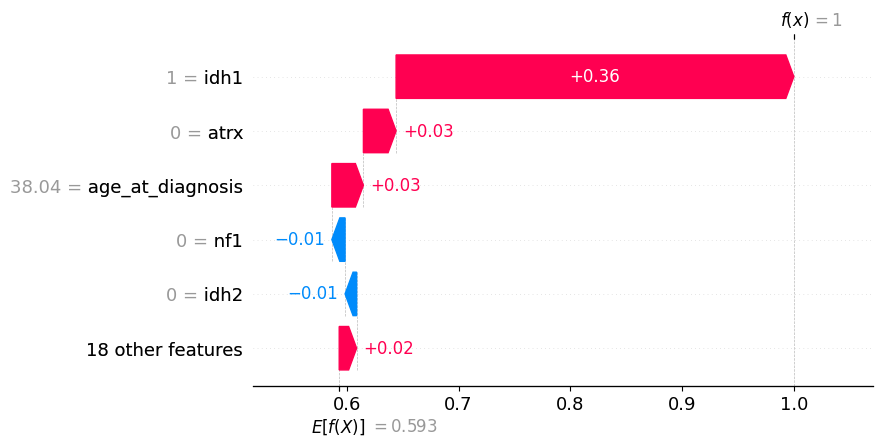

Path to prediction for index no in X100:  23
Predicted class:  0


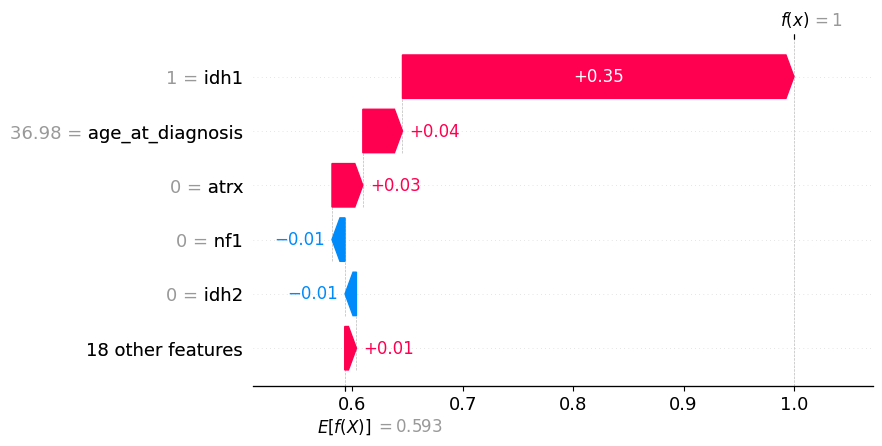

Path to prediction for index no in X100:  3
Predicted class:  0


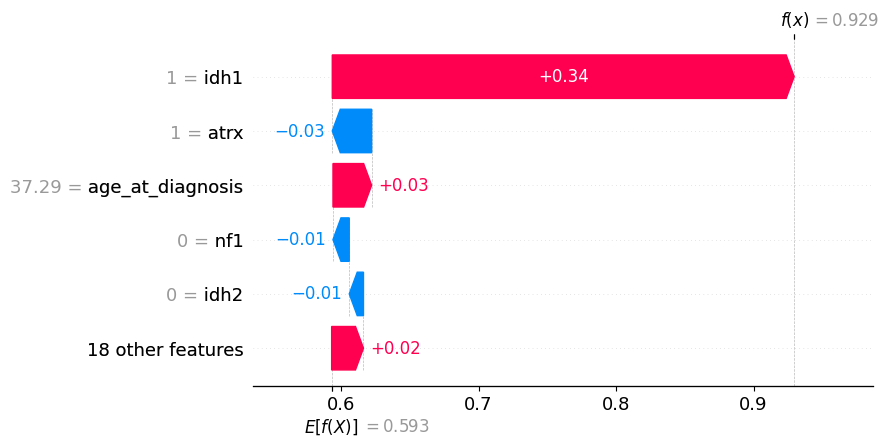

Path to prediction for index no in X100:  70
Predicted class:  0


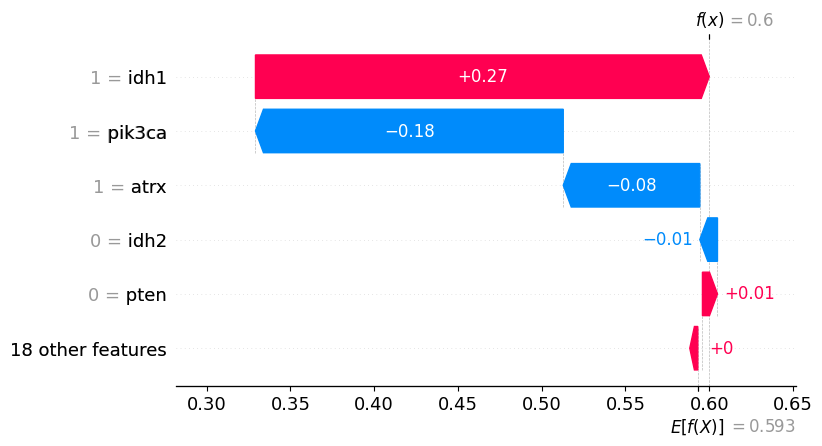

In [32]:
# Get leaf assignments for SHAP samples
leaf_ids_X100 = best_model.apply(X100) #.apply is amazing! 
# "Return the index of the leaf that each sample is predicted as" -sklearn.treeclf documentation

# Find unique leaves and therefore unique paths down the tree
unique_leaves = np.unique(leaf_ids_X100)
print(f"{len(unique_leaves)} unique leaves in sample")
print("plot_tree has 12 leaves so this is promising. Decent sign X100 is a representative sample")


# Create one waterfall for each leaf
for leaf in unique_leaves:
    
    obs_idx_in_X100 = np.where(leaf_ids_X100 == leaf)[0][0] #check if values in variables match and grab index number [0][0]

    print("Path to prediction for index no in X100: ", obs_idx_in_X100)
    representative_obs = X100.iloc[[obs_idx_in_X100]] #grab data from current "unique" index
    pred=best_model.predict(X100.iloc[[obs_idx_in_X100]])[0]

    print("Predicted class: ",pred ) #Adding prediction to show what the model is
    # waterfall plot by running "uniqe path to leaf sample" through explainer
    shap_values = tree_explainer(representative_obs) #Now we run shap equation on the single observation
    shap.plots.waterfall(shap_values[0, :, pred], max_display=6) # Auto slicing towards the predicted class

In this little code snippet i made shap visualizations of the path down the decision tree.  
I wont go into detail for each plot.  
I got the core idea when reading up on how shap values are calculated for a tree.  
And I realized that one should be able to pair these alongside a plot_tree while explaining how the model does its predictions.  
When having all these up maybe one shouldn't think too hard about magnitude of each shap value.  
Its more like "these 5 feature are the ones we need to care about" (for this specific tree model!)

Predicted class:  1


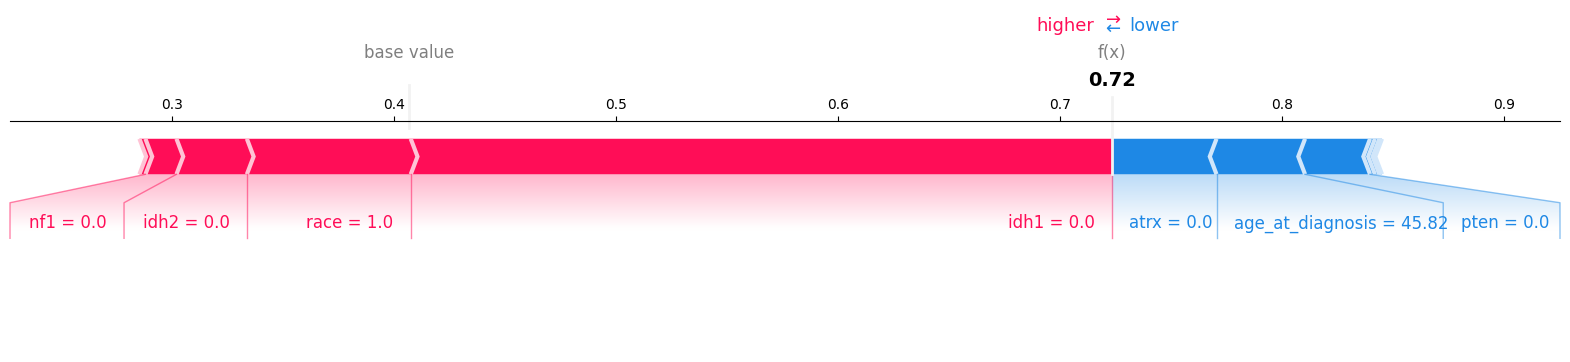

In [33]:
obs_idx_in_X100=0 #0=totally random index!
pred=best_model.predict(X100.iloc[[obs_idx_in_X100]])[0]

print("Predicted class: ",pred ) #I like this setup to auto direct the plot towards the prediction

shap.plots.force(shap_tree_vals[obs_idx_in_X100, :, pred], matplotlib=True)

.force plot, in contrast to .waterfall, shows how much each features marginal contribution push the probability value to its final number both positive and negative.  
I guess one could do the same procedure as with waterfalls to visualize each leaf path down the tree if you want something tighter.  

But I think force plot is better than waterfall for showing an individual stakeholder how the model is calculating their outcome.

In this specific instance we once again see idh1 contribute the most log~0.3 and interestingly race! race=1 is equivalent to "asian".  
Considering the fact that there are 14 asians in the dataset I vote this is just random chance more than anything.  
I'm no expert in ethnicity's relation cns cancer so maybe there's a huge incidence of that in asia? Or more idh1 mutations there.  
But after entertaining that thought for 10 seconds I think the better thing is to drop ethnicity and rerun the giant gridsearch at this point.  
No Atrx or pten mutations and that the patient is relatively young (actually at the breakpoint for the bimodal hist observed earlier!) seems protective.

### Feature level shap analysis

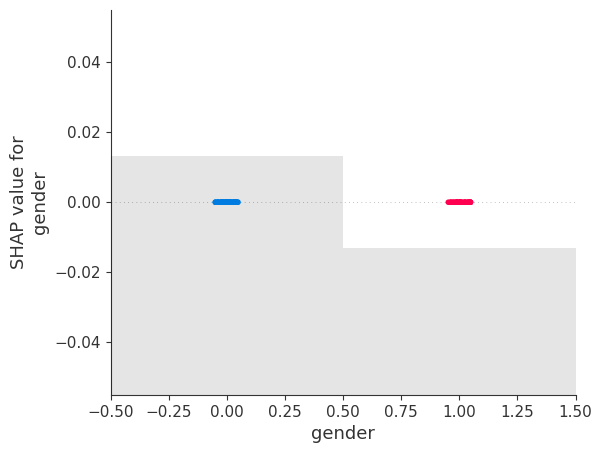

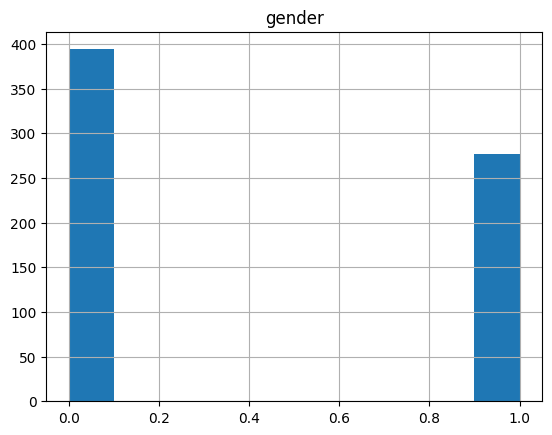

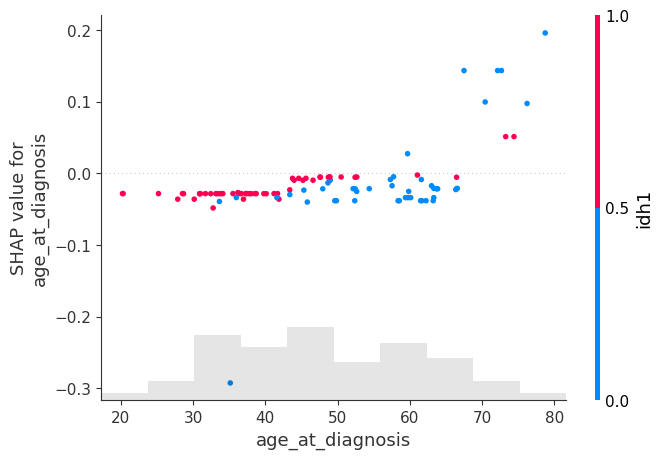

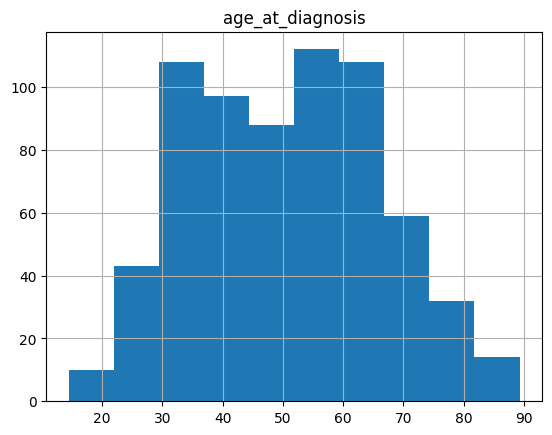

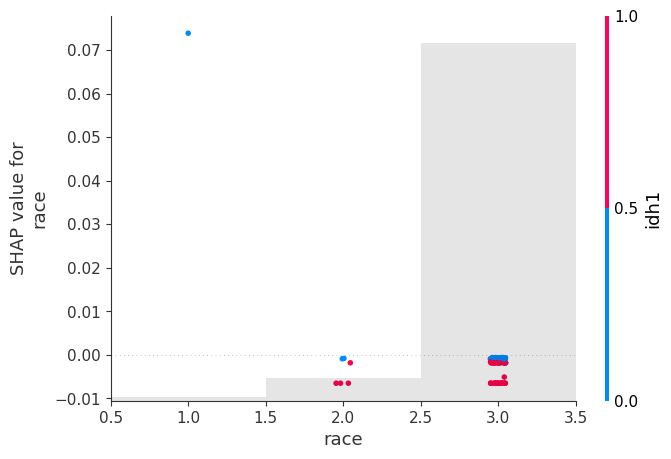

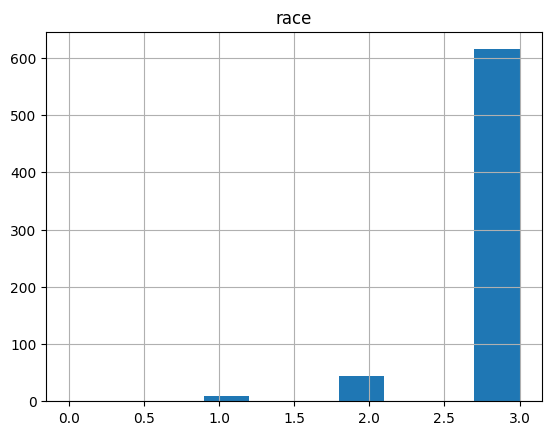

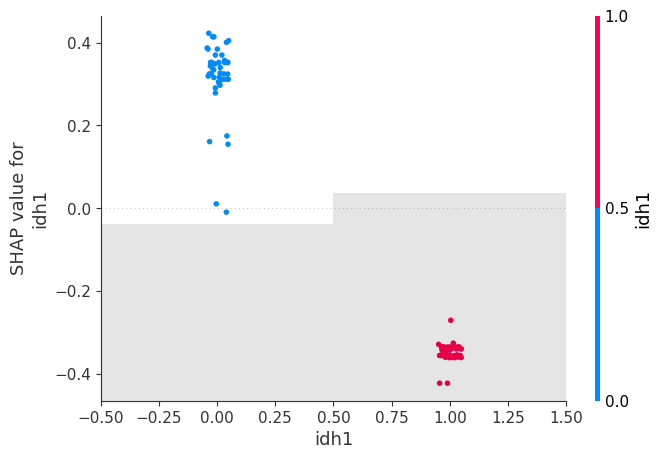

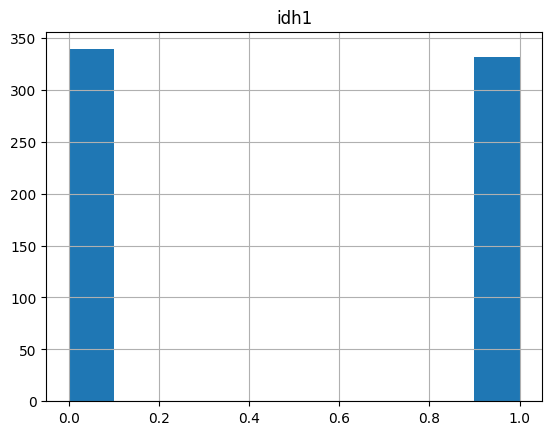

In [34]:

xcols=X.columns

#trying to avoid wall of output by slicing a bit
xcols_slice1=xcols[0:4]
xcols_slice2=xcols[4:8]
xcols_slice3=xcols[8:12]
xcols_slice4=xcols[12:16]
xcols_slice5=xcols[16:20]
xcols_slice6=xcols[20:]


for c in xcols_slice1:
    shap.plots.scatter(shap_tree_vals[:, c, 1], color=shap_tree_vals[:, "idh1", 1])
    plt.show()  # Display each plot separately
    X_train.hist(c)

I did double plot printout here to eyeball if the sampling distribution was similar to the training set.  
Supposedly shap.utils.sample is going to make a distributed rather than pure random sample but i wanted to be sure.  
Eyeballing seems good.

Note: Tried coloring by "race" to tie back to earlier EDA and race->idh1 comments but there are way too few samples in the dataset in general to tease anything out this way too.  
I tried both with age as it is continuous and idh1 since it has consistently been the most high impact feature across eda, model eval and shap plots.  
There also seems to be some form of relation between what I see in these plots and feature correlations in .corr during eda.  
notch1 and idh1 are moderatly correlated with 0.18 and shap splits them cleanly.  
Not a biological expert but the tree model implies that if we know idh1 we implicitly know notch1 and it doesn't matter for predictions.  
Maybe we can save some money on making lab assay smaller?!

Age in of itself is also fairly big. The older you are the higher incidence of not having an idh1 mutation and therefore losing its "protection" if that is an accurate word.  

But the real big and surprising one seems to be gender! earlier corr shows very very small linear relationship.  
I cant tell if this is a spurious model fit or some real interaction. I need a geneticist.

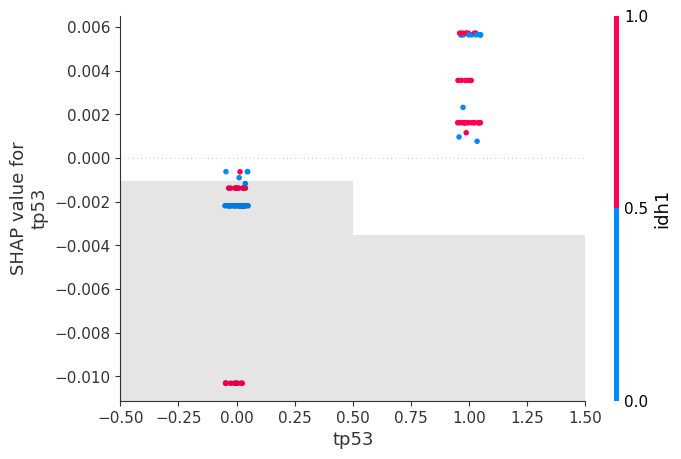

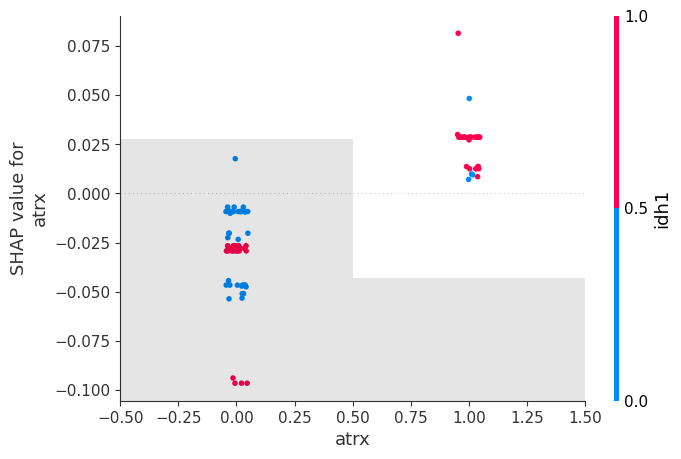

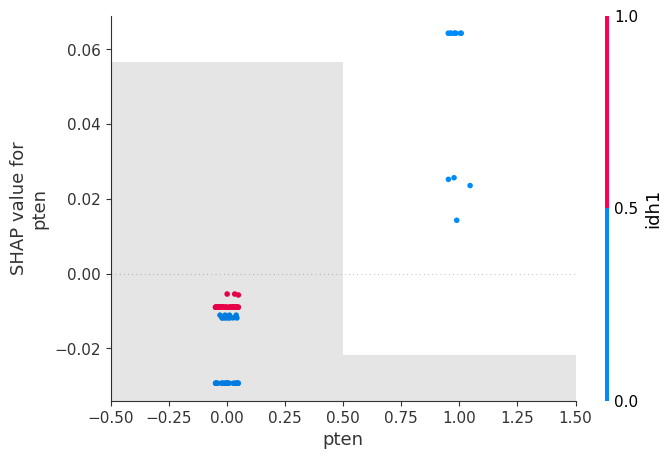

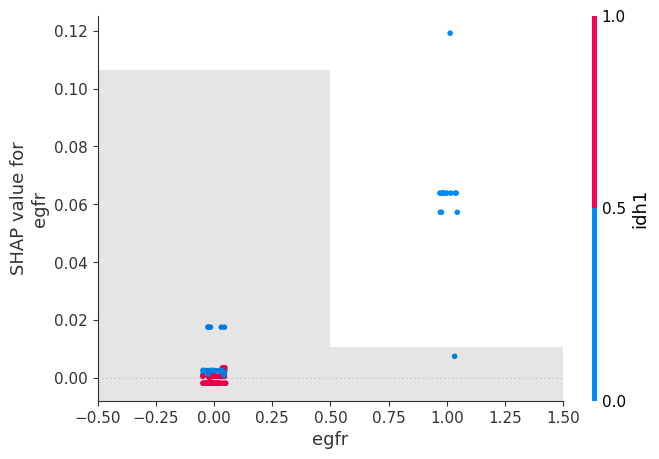

In [35]:
for c in xcols_slice2:
    shap.plots.scatter(shap_tree_vals[:, c, 1], color=shap_tree_vals[:, "idh1", 1])
    plt.show()  # Display each plot separately


Slice 2 was less interesting. But that is presumably because a tree with max_depth=5 realistically wont account for 20 features and the fact that idh1 ~0.3 log  
But I think Im letting myself get fooled by the log scale. Sure 0.3 is huge and ~0.05 is small but that number is far from nothing.  

In [36]:

print("Probability at 0.3 log odds", float(1/(1 + np.exp(-0.3))))
print("Probability at 0.05 log odds", float(1/(1 + np.exp(-0.05))))
print("Difference between the two values", float(1/(1 + np.exp(-0.3)))-float(1/(1 + np.exp(-0.05))))

Probability at 0.3 log odds 0.574442516811659
Probability at 0.05 log odds 0.5124973964842103
Difference between the two values 0.0619451203274487


Yeah I let myself be fooled by the log scale. 0.3 looks way bigger than 0.05 but in probability land and the real world its a 6% difference between the 2
At this point i just want to change my exlpainer from log to proba. Interpreting log is quite convoluted.

In [37]:
#probability explainer
tree_explainer_p= shap.TreeExplainer(best_model, model_output="probability", 
                                     feature_perturbation="interventional", #hese 2 are needed for probability output 
                                     data=X_train[:100])  #this is according to docs, not quite sure why


shap_tree_vals_p=tree_explainer_p(X100)

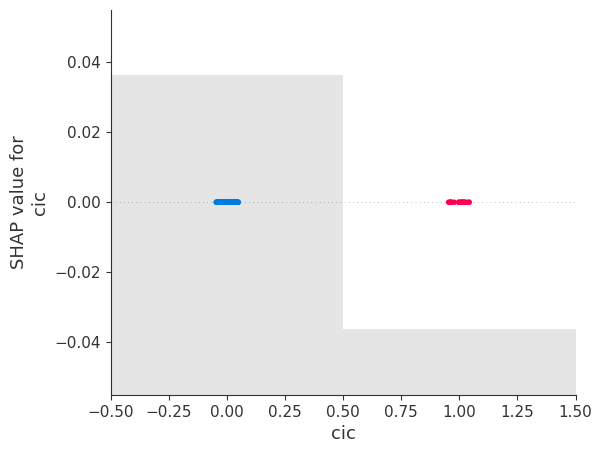

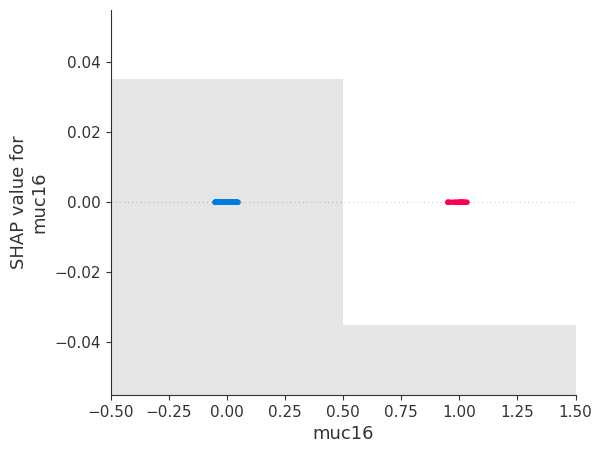

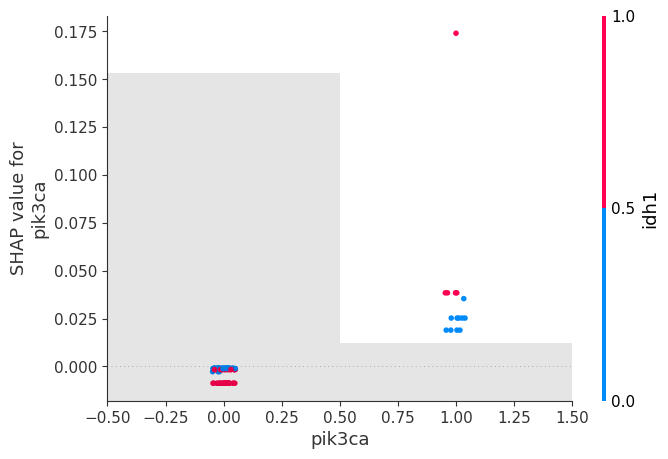

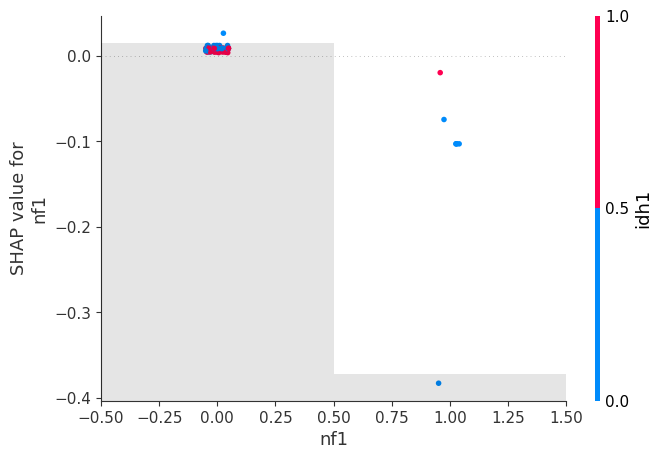

In [38]:
for c in xcols_slice3:
    shap.plots.scatter(shap_tree_vals_p[:, c, 1], color=shap_tree_vals_p[:, "idh1", 1])
    plt.show()  

Much better! Its interesting to see how idh1 seems to split along several mutations that make no difference for the actual outcome according to the tree.  
It might be the case that the tree is good at diagnosing, good for explainability but miss a ton of gene-gene interaction due to shallow depth.

But Im starting to feel a bit of redundancy with this plot so Ill just rerun idh1 in probability space and call it on scatter.
I think that for a real life scenario I would go through each plot in detail and then extract the top 5-10 plots for reporting to stakeholders.  

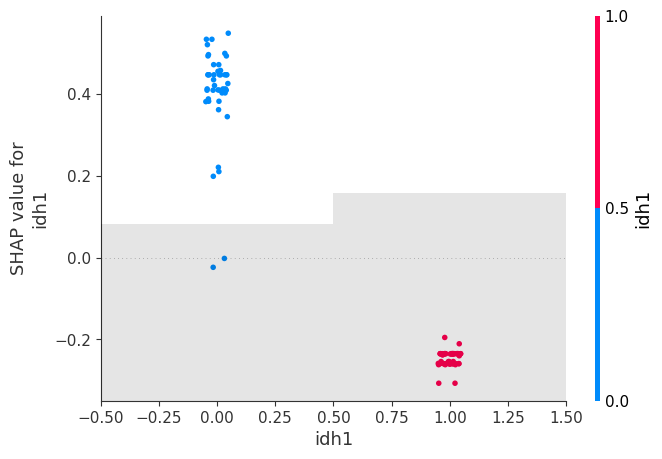

In [39]:
shap.plots.scatter(shap_tree_vals_p[:, "idh1", 1], color=shap_tree_vals_p[:, "idh1", 1])

Reran idh1 plot in probability and now we can see lower bound be more limited (was ~-0.5 before).  
This shows more clearly that idh1 mutation is more of a risk reducer a |0.4|nd a non mutation is less of a risk enhancer |0.2|.  
I let myself be fooled by logscale.  

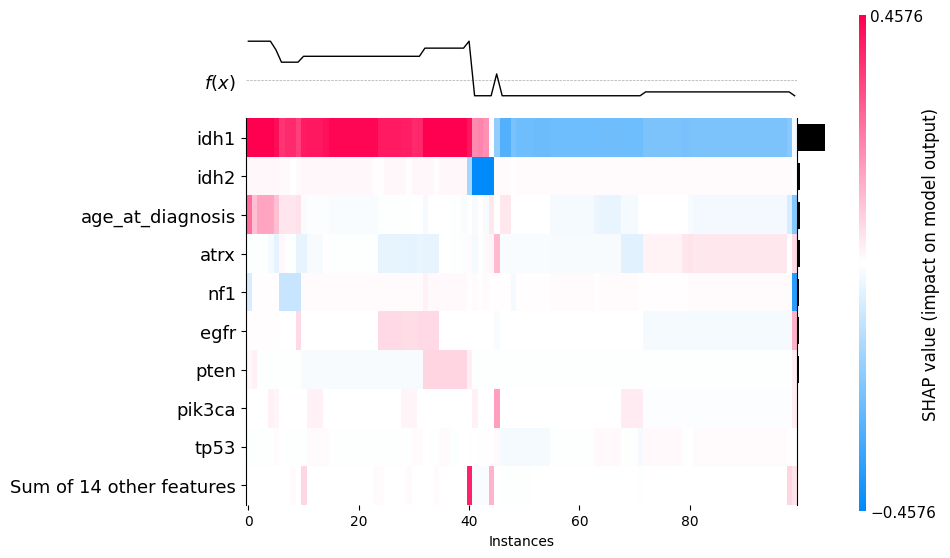

<Axes: xlabel='Instances'>

In [40]:
#heatmap
mean_abs_shap = np.abs(shap_tree_vals_p[:, :, 1].values).mean(axis=0)
feature_order = np.argsort(mean_abs_shap)[::-1] #figured id want the biggest features first
#print(feature_order, X_train.columns) confirming feature order maps to correct feature
shap.plots.heatmap((shap_tree_vals_p[:, :, 1]), feature_order=feature_order)

In my mind heatmap is made up of N waterfall plots squashed together and stacked horizontally.  
The squashing of big shap values/bars in each waterfall makes that small slice more intense  
whereas a squash of a small shap/bar makes the color more faded  
Seems to me that one should run this with a waterfall plot to see if you have a bit of an outlier observation in your waterfall or if it follows the general trend of the model.  
Otherwise the only new thing is that idh2 mutations seem to be protective for a few observations. That feature wasn't included in the earlier scatters so Ill just run it below to confirm.

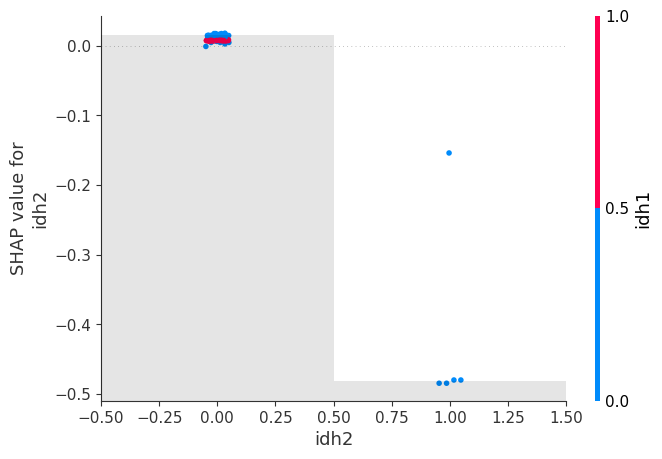

In [41]:
shap.plots.scatter(shap_tree_vals_p[:, "idh2", 1], color=shap_tree_vals_p[:, "idh1", 1])

Yes. Idh2 mutation is protective for a few observations.  
I think the picture is getting too convoluted for me to make any non educated hypothesis by this interaction apart from the fact that .corr showed a -0.11 correlation with grade. So there is most likely a signal.  
I need a geneticist to explain all of these interactions!  

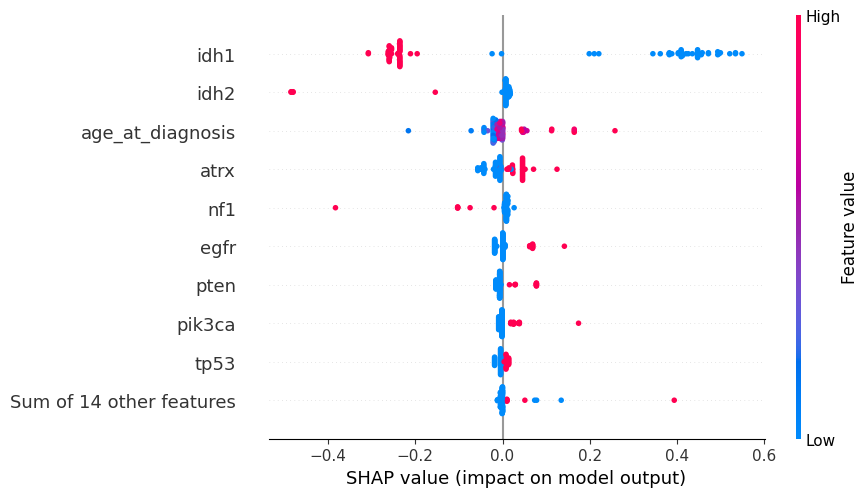

In [42]:
shap.plots.beeswarm(shap_tree_vals_p[:, :, 1]) 


I think of beeswarm as N waterfall plots where each feature start from baseline and you just see the edge of each waterfall bar.
To illustrate this I did a small workaround and made a single bee plot below  

But I think this is more readable than .heatmap in order to se what features are considered important for the model and their relative 
impact on output.  
I actually think that I would start with this plot rather than individual illustrations as suggested by lab instructions. Great for overview.  

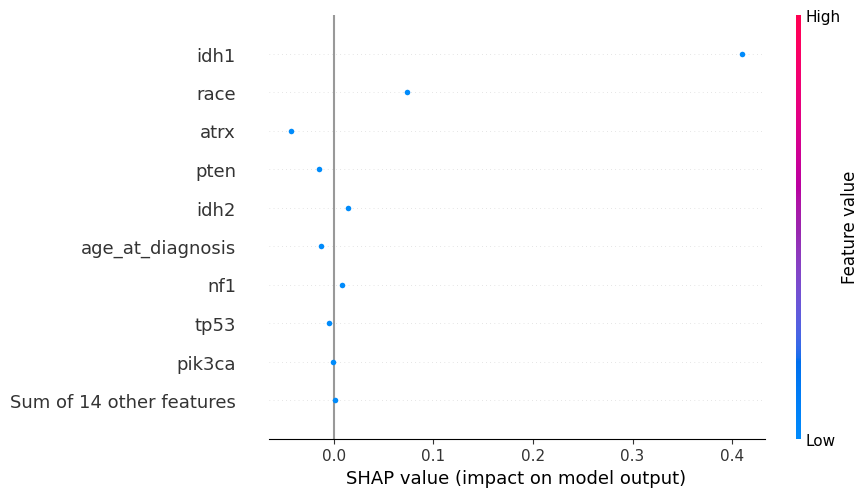

In [43]:
shap.plots.beeswarm(shap_tree_vals_p[[0], :, 1]) 
#Beeswarm does not support single observations but you can work around that by passing a "matrix" of a single observation 

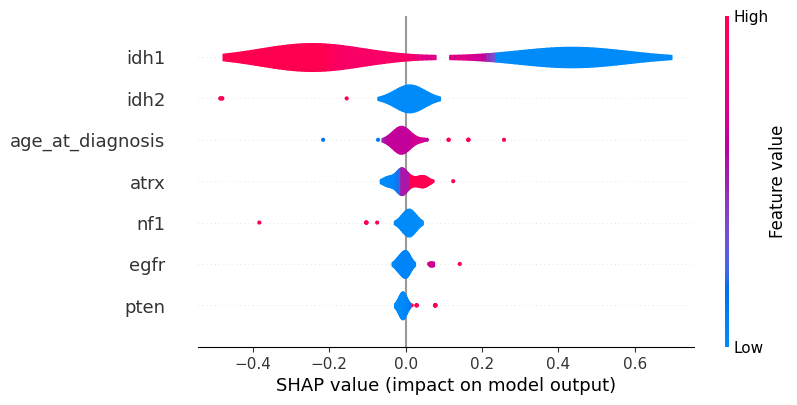

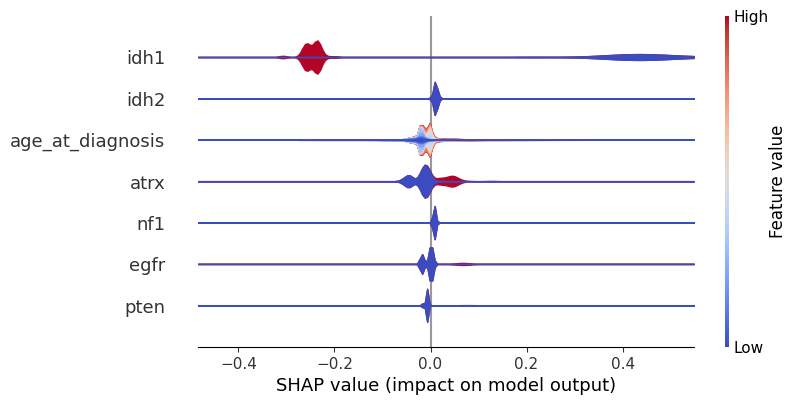

In [44]:
#violin == Fancy beeswarm
shap.plots.violin((shap_tree_vals_p[:, :, 1]), max_display=7, plot_type="violin")
shap.plots.violin((shap_tree_vals_p[:, :, 1]), max_display=7, plot_type="layered_violin")


Seems to me that violin plot is more or less a .beeswarm with a KDE slapped on top of it.  
It might have some uses if my shap evaluation dataset is huge and beeswarm becomes unreadable.  
But for this set of 100 samples it does not add anything over beeswarm.  
plot_type="layered_violin" splits by feature and make 2 KDEs one for high values and one for low values of that feature.  
Since this dataset is almost all binary this makes for a terrible plot.  
Only continious value is age_at_diagnosis where we can see some coloring.

In [45]:

# Has to be in browser due to VSC dont liking interractive plots. And I like VSC
#100 force plots flip them 90 degrees and .hstack them
force_plot = shap.plots.force(shap_tree_vals[0:99, :, 1])
shap.save_html("multi_force_plot.html", force_plot)
webbrowser.open("multi_force_plot.html")


True

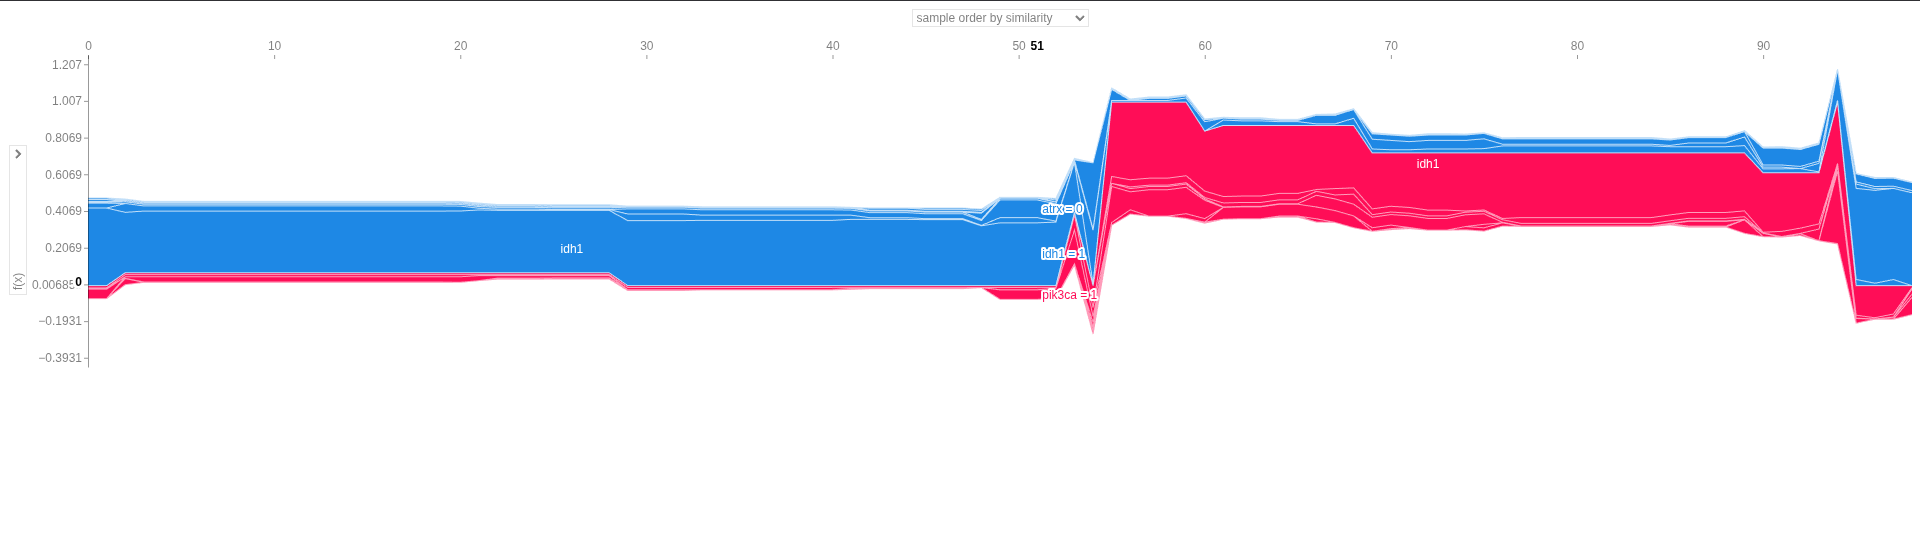

In [46]:

Image(filename="multi_force.png", width=800)

Made a screenshot of web browser display from the code above so one can see it here.  
But its better to do this code in jupyter or view the interactive plot in the browser.  

This might be a better way to visualize model behavior than beeswarm for the client who wants  
slightly more detail and a more correct understanding of how competing forces affect model output.  
But I *think* beeswarm covers the needs for most stakeholders and its easier to interpret.  
In addition to a geneticist for earlier questions on gene interaction I also need a patient stakeholder to test this out on.  


### Summary from shap values of a single Decision tree:  
When doing model selection, tuning and performance evaluation I chose the Decision Tree because it is simple to explain and performs well.  
But when looking at the shap values I understand that we loose a lot of feature interactions. An extreme L1 regularization, if you will.  

I think I will use NBG as next target since it works totally different than a single tree.  
I will also go from feature level to individual level analysis as I believe it makes more sense from a workflow perspective.  

## NGB Shap

In [47]:
#retraining NBG by extracting model from giant gridsearch
NBGmodel = performing_models[0]["estimator"]

NBGmodel.fit(X_train, Y_train) #No scaling really needed for bayes either

NBG_test_pred=NBGmodel.predict(X_train)

NBG_pred=NBGmodel.predict(X_test)


NBGsensitivity_train=recall_score(Y_train, NBG_test_pred)
NBGsensitivity_test=recall_score(Y_test, NBG_pred)
print("Sensitivity scores NBG train/test: ",NBGsensitivity_train ,NBGsensitivity_test)

Sensitivity scores NBG train/test:  0.9413919413919414 0.9240506329113924


Opening in existing browser session.


PermutationExplainer explainer: 101it [00:11,  5.51it/s]                        


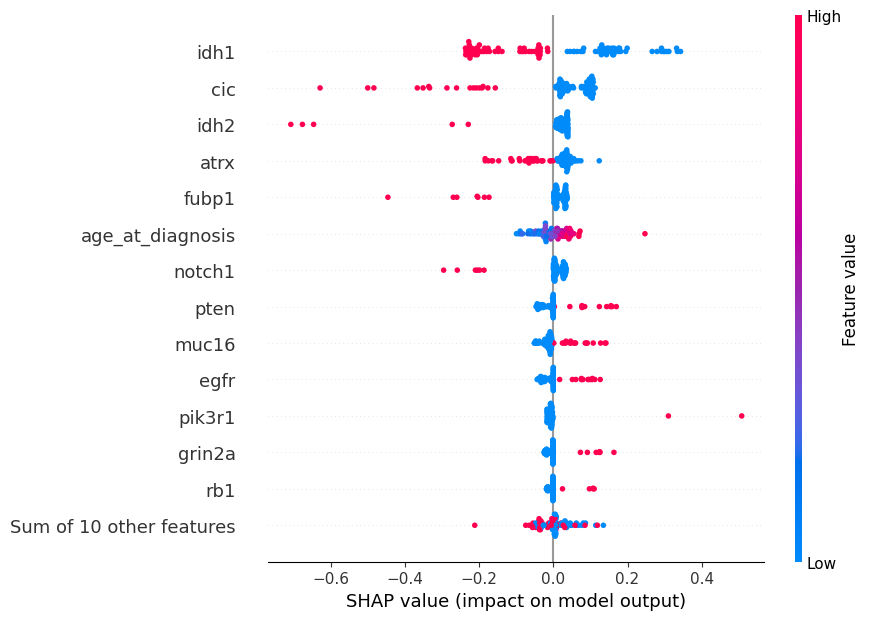

In [48]:
#creating new explainer
NBGexplainer= shap.Explainer(NBGmodel.predict_proba, X100) #had to ask NBG to output probability values
#And it seems .explaintree doesnt need the "shap training" observations.  
# I guess thats because the recursive calculations can be done after the method object is created

shap_NBG_vals=NBGexplainer(X100)
shap.plots.beeswarm(shap_NBG_vals[:, :, 1], max_display=14) 
#increasing max_display to show more features as they are more included in the model than tree

Oh wow. Totally different results!  
The fairly vague term "Model assumptions" have just become much clearer.  
I knew the models reach their targets in different ways but this was very enlightening.  
The model follows the directional trends from .corr but not the magnitude
It also show way more clearly that some mutations decrease risk/prediction.  
But not having them has smaller impact on increase of risk such as cic and idh2.  

I first thought the difference in magnitude of directional effects was because NBayes was nonlinear with all those gaussians.  
But then I reviewed the math, the decision is made the same way any linear classifier does with log odds wrapped in sigmoid.  
I kind of want to just do beeswarm on all models at this point.  
And then (once again) show them all to a geneticist and ask which one is closer to the actual truth.  
Im also very much open to revise my stance on selecting a single tree as the best model since I didn't know of shap when I made that decision.


Predicting class:  1


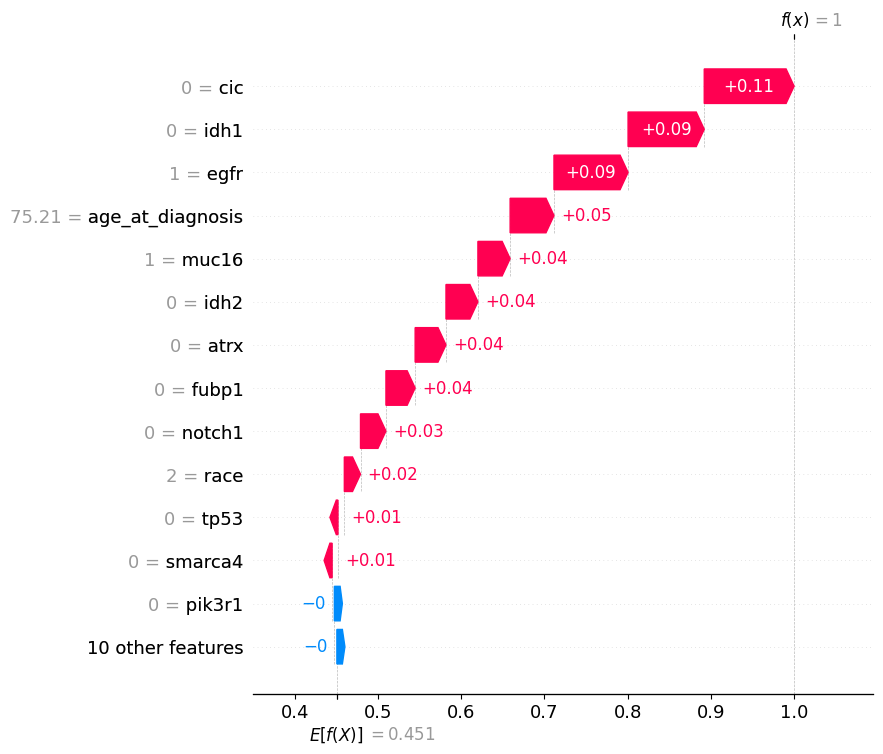

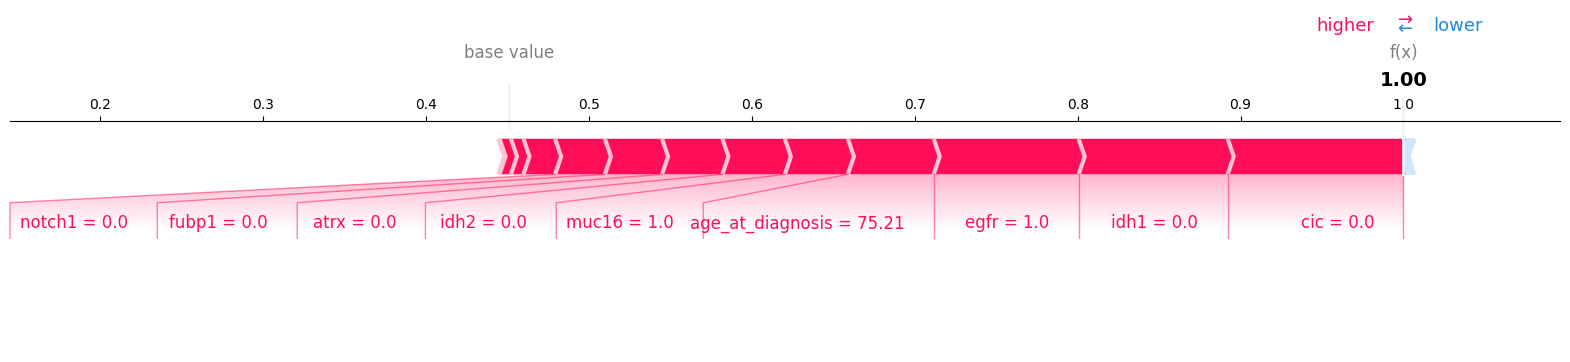

In [49]:
idx=42
single_obs = X_train.iloc[[idx]]  # One might as well grab an observation from the dataframe rather than relying on stochasticity
pred=NBGmodel.predict(single_obs)[0]



print("Predicting class: ",pred)
shap_values_single_nbg = NBGexplainer(single_obs)



shap.plots.waterfall(shap_values_single_nbg[0, :, pred], max_display=14)
shap.plots.force(shap_values_single_nbg[0, :, pred], matplotlib=True)

This is the same single observation as I handpicked for the first individual tree shap.  
This seems to follow the logic of P y=1| feature_n and just add more and more as you work through the features.  
But this one seems to be a bit of worst case scenario. Old person no idh1 mutation.  

Maybe I should have picked 0 as predictive target to make things more readable...

Predicting class:  0


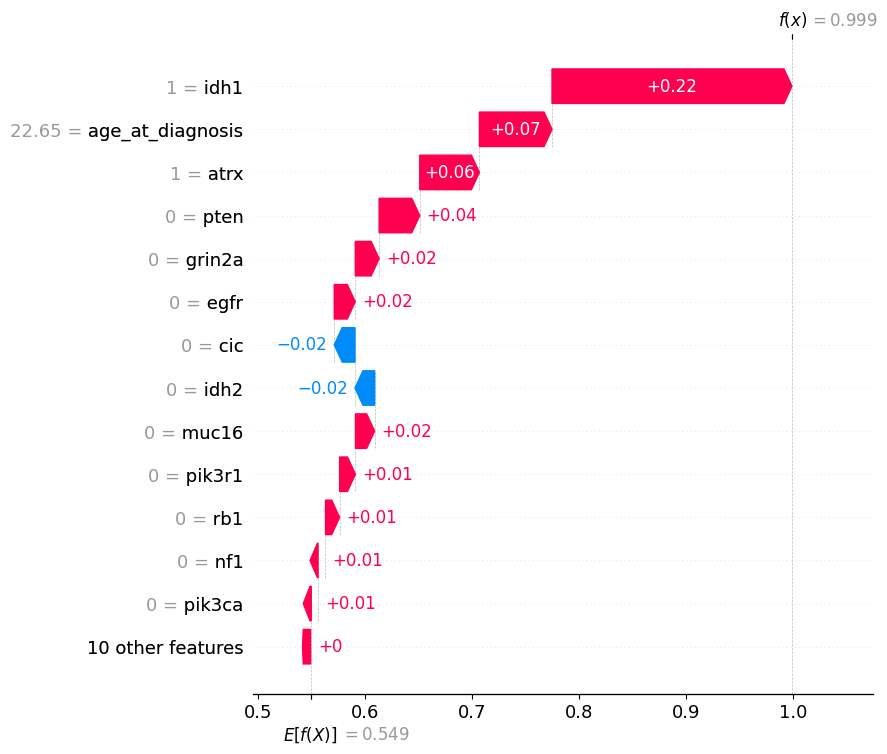

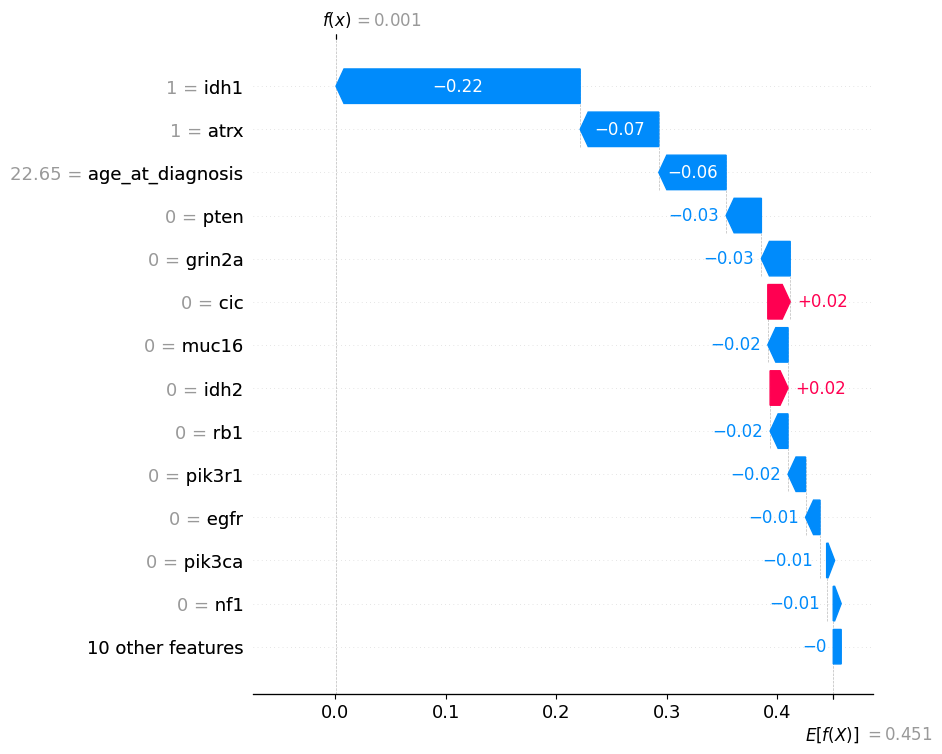

In [50]:
single_obs = X_train.iloc[[0]]  # New target at "random" .iloc[0] y = 0 
pred=NBGmodel.predict(single_obs)[0]
print("Predicting class: ",pred)
shap_values_single_nbg = NBGexplainer(single_obs)
shap.plots.waterfall(NBGexplainer(single_obs)[0, :, pred], max_display=14)
shap.plots.waterfall(NBGexplainer(single_obs)[0, :, 1], max_display=14)

Side note: I cycled through several individual observations and realized they are all extremely confident!  
It seems (from reviewing math again) that this is because the model just adds up whatever the dominant feature direction is and compare wether p1>p0  
This model is way more binary than I thought at first. If p1 is 0.0001 higher than p2 then the model will still confidently classify p1.  

And then shap calculation is only done on a single class side. Regardless if p1 was 0.001 or 0.99 higher than p2.  
When visualizing either waterfall OR force we only see the contributions towards that class and not the complement and therefore we only get half the picture.  

Performance on this problem was great, but I don't like the false confidence portrayed by the single observation shaps.  

Same principle applies to beeswarm plots - viewing only one class can 
misrepresent which features actually discriminate between classes vs. which 
just shift probabilities uniformly.

*We need a shap.BayesExplainer to see shap values for the sum of p | non predicted class to get a better sense of confidence!*  

In the meantime I think one has to show both the features pushing towards and away from the prediction by showing both classes shap values like this:  
shap.plots.waterfall(NBGexplainer(single_obs)[0, :, 1], max_display=14)  
shap.plots.waterfall(NBGexplainer(single_obs)[0, :, 0], max_display=14)  
Same with beeswarm, foce and the other plots.  

This dual-view approach better represents model uncertainty and helps 
stakeholders understand when predictions are confident vs. marginal decisions for any Naive Bayes type models.  

## SVC poly3 Shap

Sensitivity scores SVC train/test:  0.945054945054945 0.9493670886075949


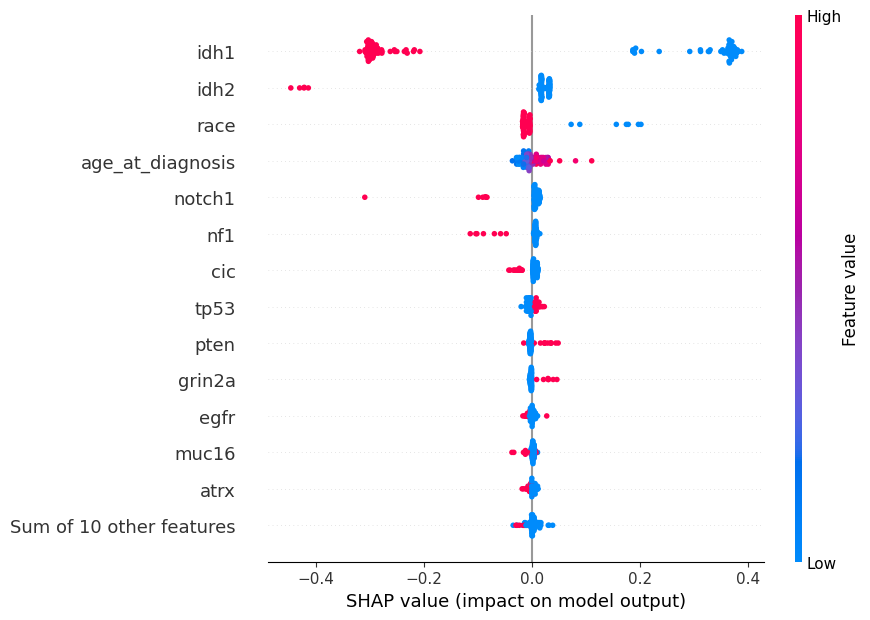

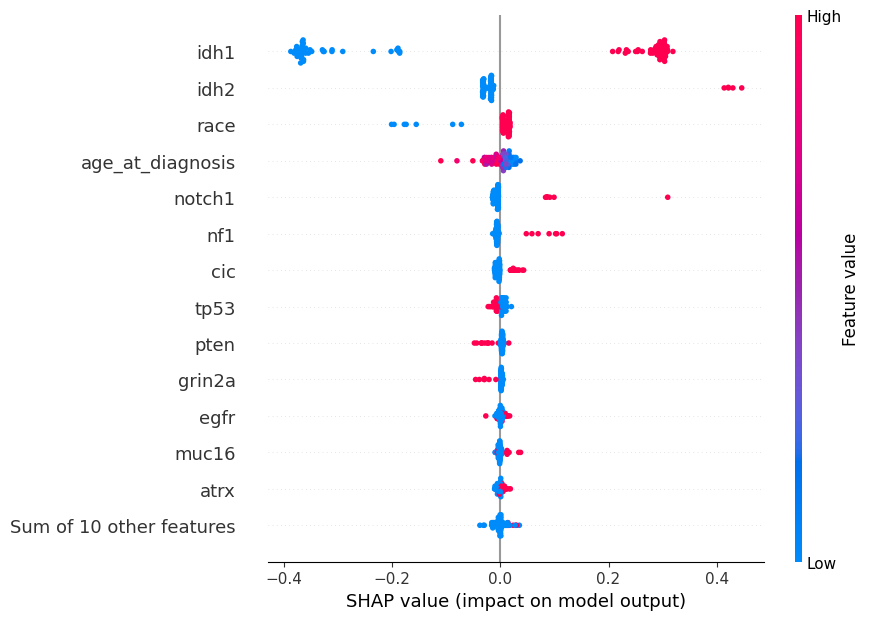

In [51]:
SVCmodel = SVC(C=1, kernel='poly', probability=True, random_state=42) #Cant reuse GridSearch model as I have to set probability=True

SVCmodel.fit(Xtrain_standard, Y_train) #Need to scale from now on though

SVC_train_pred=SVCmodel.predict(Xtrain_standard)
SVC_pred=SVCmodel.predict(Xtest_standard)
SVCsensitivity_train=recall_score(Y_train, SVC_train_pred)
SVCsensitivity_test=recall_score(Y_test, SVC_pred)
print("Sensitivity scores SVC train/test: ",SVCsensitivity_train ,SVCsensitivity_test)

X100_scaled=standard.transform(X100) #Have to scale X100 otherwise values are incorrect as compared to training data

#creating another explainer
SVCexplainer= shap.Explainer(SVCmodel.predict_proba, X100_scaled) #need probability values here too

shap_SVC_vals=SVCexplainer(X100_scaled)
shap.plots.beeswarm(shap_SVC_vals[:, :, 1], max_display=14) 
shap.plots.beeswarm(shap_SVC_vals[:, :, 0], max_display=14) 
#increasing max_display to show more features as they are more included in the model than tree

Predicting class:  1


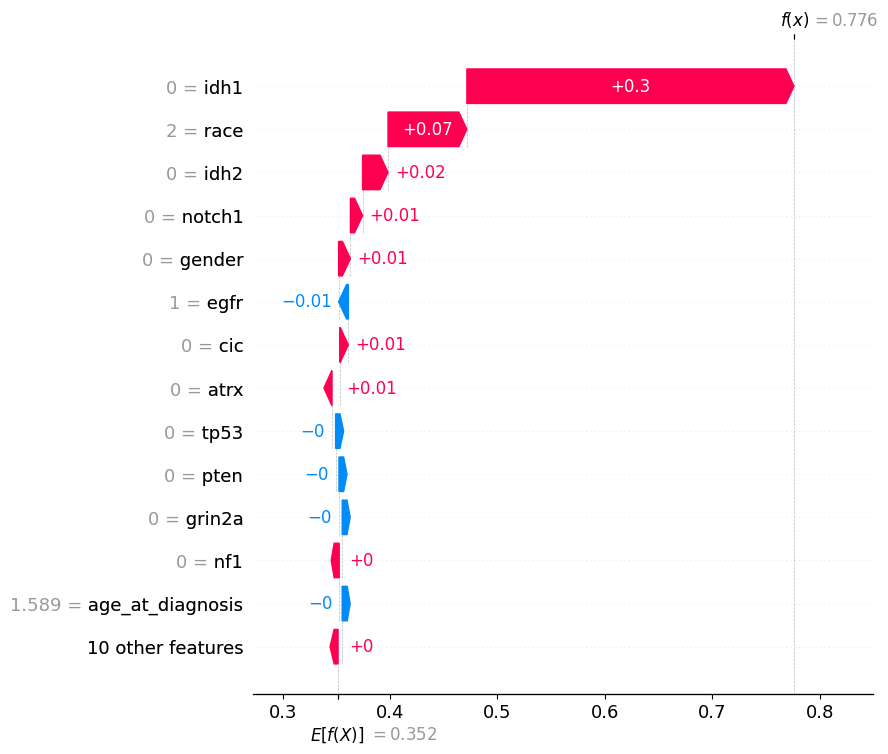

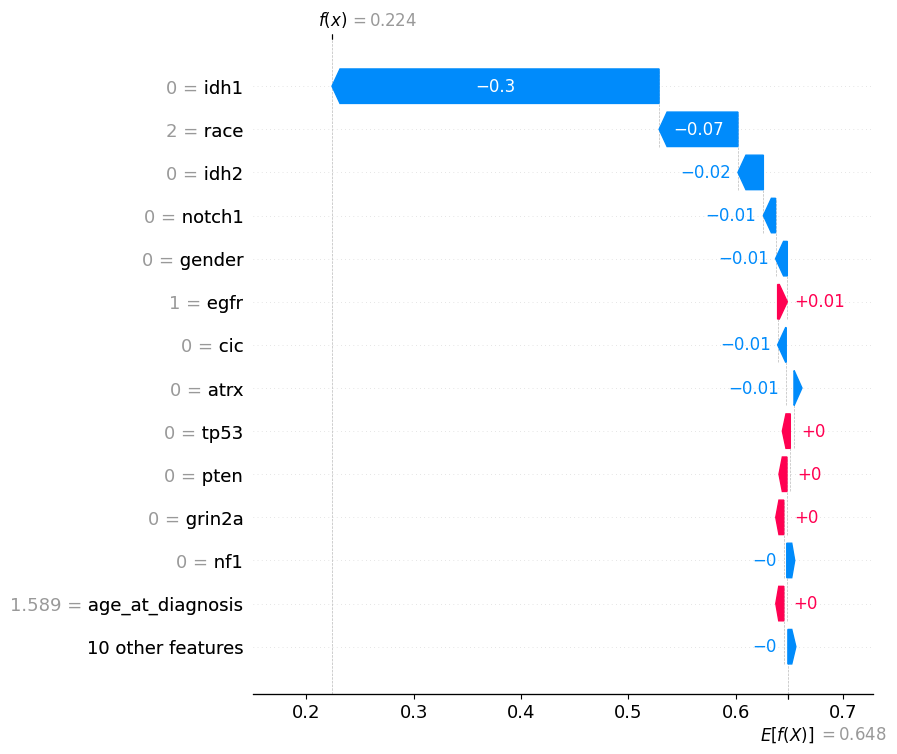

In [52]:
single_obs = Xtrain_standard.iloc[[42]]  # Reusing same observation as before
print("Predicting class: ",SVCmodel.predict(single_obs)[0])
shap_values_single_svc = SVCexplainer(single_obs)
shap.plots.waterfall(shap_values_single_svc[0, :, 1], max_display=14)
shap.plots.waterfall(shap_values_single_svc[0, :, 0], max_display=14)

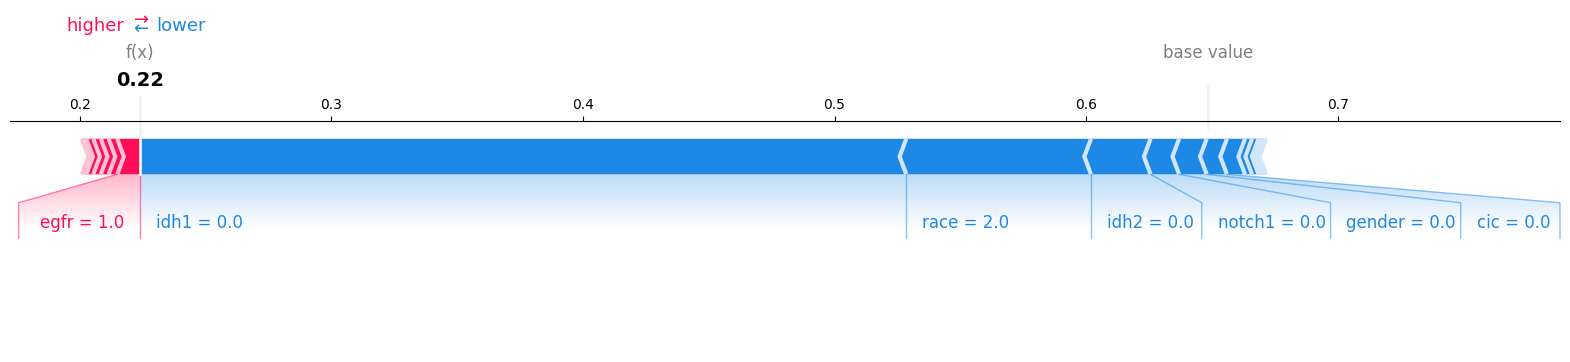

In [53]:
shap.plots.force(shap_values_single_svc[0, :, pred], matplotlib=True)


The pattern on both feature and individual level is like an L1 exaggerated version of what I saw in NBG.  
From what I gather, refreshing my math on SVM.  
If a single observations feature is identified as an important point for placing the border then the full fow will be used as support vector points.  

When shap then runs the math it very much identifies that features importance and therefore "regularizes away" the other features.  
Since they probably made little difference because we placed the support vector border with feature 1. Idh1 in this case again.  

It also seems to me that all top performing models are "greedy" and use a few features for prediction and push them really hard.  
This in contrast to earlier EDA notes on several features showing linear relationships with prediction.
I think thats a matter of most features in this dataset being binary.  

Im almost depressed by the fact that these top performing, fairly explainable models are probably missing a ton of nonlinear and fractional relationships. But I guess thats a tradeoff you have to make.  

## Gboost
Will I finally see many small shap values in either direction?

Sensitivity scores SVC train/test:  0.9267399267399268 0.9367088607594937


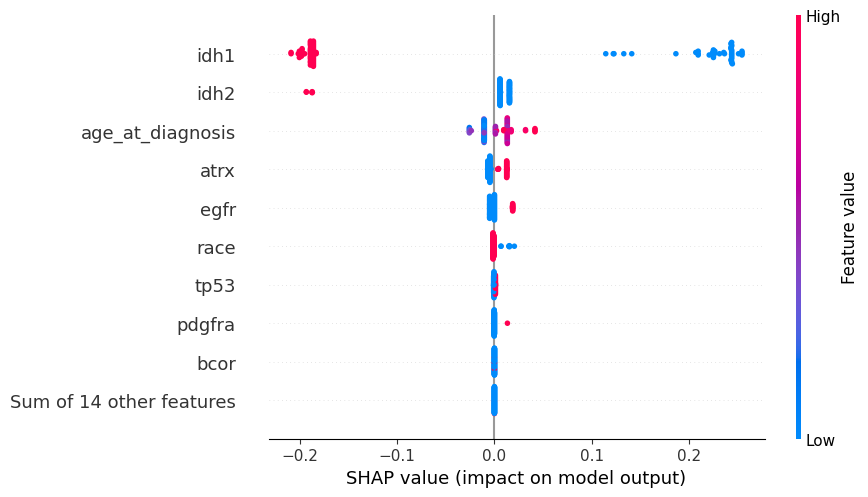

In [54]:
GBmodel=performing_models[4]["estimator"] #gradient boost learning_rate=0.01, max_depth=2, random_state=42


GBmodel.fit(Xtrain_standard, Y_train) #Need to scale from now on though

GB_train_pred=GBmodel.predict(Xtrain_standard)
GB_pred=GBmodel.predict(Xtest_standard)
GBsensitivity_train=recall_score(Y_train, GB_train_pred)
GBsensitivity_test=recall_score(Y_test, GB_pred)
print("Sensitivity scores SVC train/test: ",GBsensitivity_train ,GBsensitivity_test)


#creating another explainer
# reusing earlier tree_probability code for this as gboost is a tree
GBexplainer = shap.TreeExplainer(
    GBmodel,
    model_output="probability",  #
    feature_perturbation="interventional", 
    data=X100_scaled
)

shap_GB_vals=GBexplainer(X100_scaled)
shap.plots.beeswarm(shap_GB_vals) 


Predicting class:  1


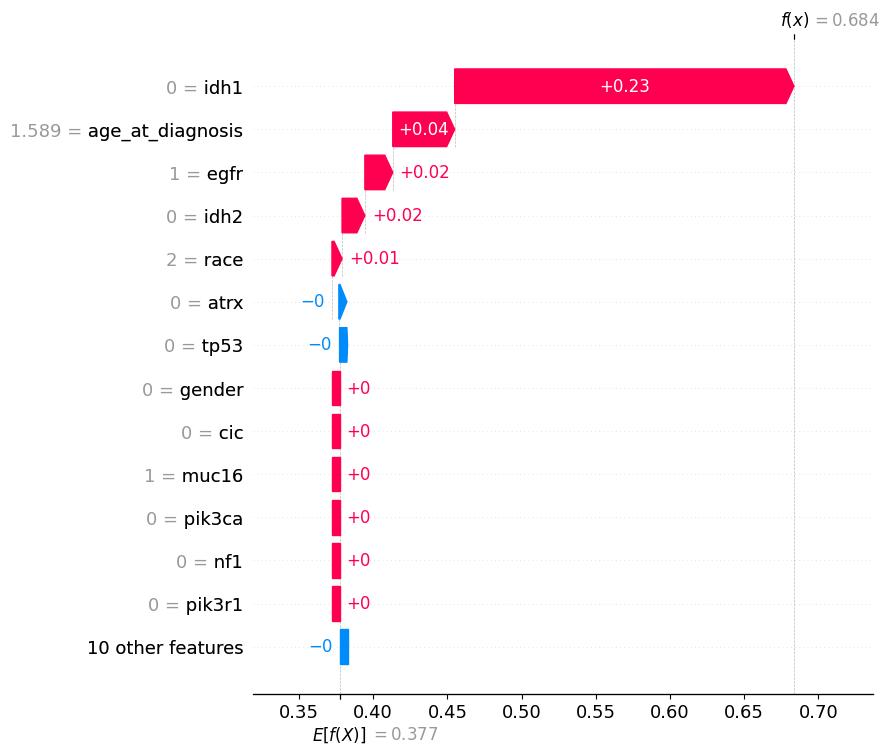

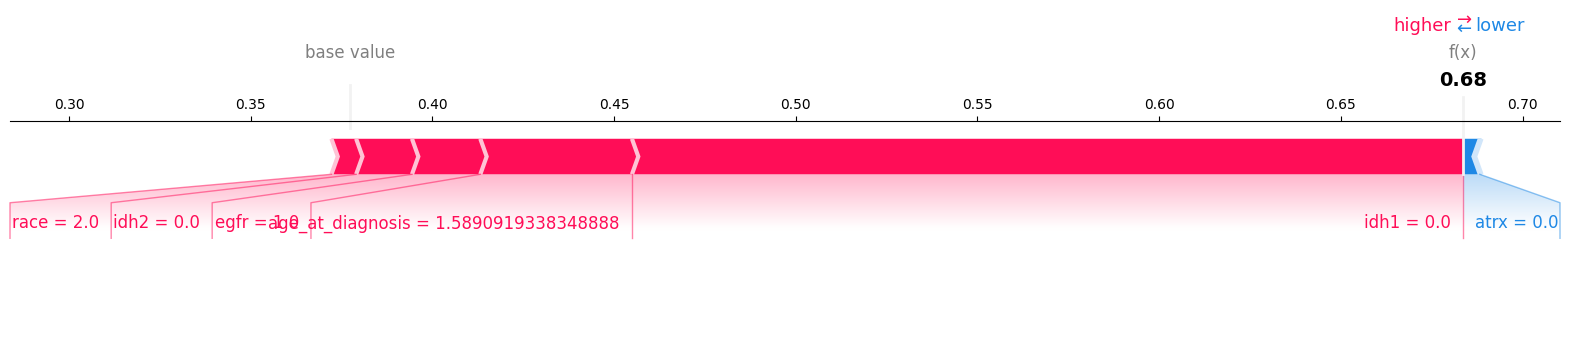

In [55]:
idx=42
single_obs = Xtrain_standard.iloc[[idx]] 

pred=GBmodel.predict(single_obs)[0]

print("Predicting class: ",pred)
shap_values_single_gb = GBexplainer(single_obs)
shap.plots.waterfall(shap_values_single_gb[0], max_display=14)
#Since we are talking tree models. Doing force and waterfall both is redundant 
shap.plots.force(shap_values_single_gb[0], matplotlib=True)

In [56]:
print(f"Age (original): {X_train.iloc[idx]['age_at_diagnosis']:.1f} years")

Age (original): 75.2 years


Well this was surprising. This model pretty much only uses idh1 too.  
I guess thats as close I can get to a confirmation that this is an important gene.  
Only issue here is that since I have to scale data for SVC to work. So age is a bit on the plot.  
For now I just printed the original age using the same index. Might be a better way to do this.  

Prediction reminder: 1


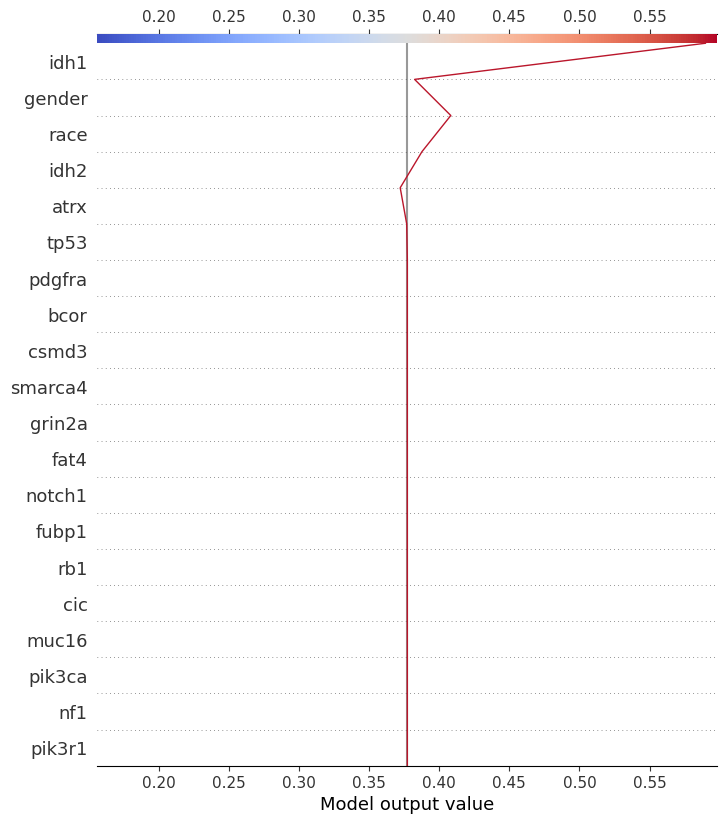

In [57]:
#Bonus. Found this neat little thing!
print("Prediction reminder:", pred)
shap.decision_plot(shap_GB_vals.base_values[0], #need base value for vertical line (reusing idx 42 once again)
                   shap_GB_vals.values[0], #Bit if a redundant argument that I need to slice the same way for some reason
                   X.columns,#feature names                   
                   plot_color="coolwarm") #Can change both scale and line color! 

Hah! I finally found what I wanted. Decision_plot shows "negative" shap values in relation to the models predicted class for a single observation.  
Im changing my mind again. Beeswarm[0, :, 1],Beeswarm[0, :, 0] and decision_plot OR force plot will cover 80% of explanation needs for model and individual predictions.  

# Summary SHAP  
### See "Extra learning and notes lab 2" for more detailed walkthrough on shap math and logic  
### There is also a bootstrap experiment "Going overboard with statistics on shap" down at the bottom

I find the idea of shap very compelling. Its supposedly a tool for explaining models to stakeholders,  
but to me it ended up being very enlightening on model behavior and "model assumptions".  
A phrase used by teachers that never really meant anything to me before this.
Its a shame this is not part of the main program and is only part of AI healthcare.  
This is both great for learning and should probably be mandatory in any highly regulated (or high trust!) sector such as law and finance.  

<div class='alert alert-block alert-success' style="font-weight:bolder">

# Extra learning and notes lab1
Not relevant to actual lab tasks but I want them in the same file for reference.  
Feel free to ignore.  

</div>

### Trying to learn voting classifiers

In [58]:
# I have now learned that it was a bad idea to do a giant gridsearch! It would have been better to do one for each model
# source https://machinelearningmastery.com/voting-ensembles-with-python/

voters=["soft", "hard"]
for v in voters:
    
    print(v, "vote")
    voting_ensemble = VotingClassifier(estimators=[
        #NOTE Added one model at a time and commented it out if it didnt improve or decrease the ensemble performance
        ("Bayes",GaussianNB(var_smoothing=1e-09)),
        #("SVC", SVC(kernel="poly",C=1, degree=3)),
        #("PassiveAgressive", PassiveAggressiveClassifier(random_state=42, C=0.001, loss="hinge")),
        ("Gboost", GradientBoostingClassifier(learning_rate=0.01, max_depth=2, 
                                              max_features=None, min_samples_leaf=1, 
                                              min_samples_split=2, n_estimators=100)),
        ("Tree", DecisionTreeClassifier(max_depth=5)),
        #("Forest", RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100)),
        ("Logreg", LogisticRegression(random_state=42, C=1, penalty="l2")),
        #("KNN", KNeighborsClassifier(metric="l1", n_neighbors=17)),
    ],
    voting=v
        )


    voting_ensemble.fit(Xtrain_standard, Y_train)
    ensemble_train_pred = voting_ensemble.predict(Xtrain_standard)
    ensemble_test_pred = voting_ensemble.predict(Xtest_standard)

    sensitivity_train=recall_score(Y_train, ensemble_train_pred)
    sensitivity_test=recall_score(Y_test, ensemble_test_pred)

    print("Train sensitivity: ", sensitivity_train,"Test sensitivity: ", sensitivity_test)

soft vote
Train sensitivity:  0.945054945054945 Test sensitivity:  0.9493670886075949
hard vote
Train sensitivity:  0.9267399267399268 Test sensitivity:  0.9240506329113924


In [59]:
soloGauss=GaussianNB(var_smoothing=1e-09)
soloGauss.fit(Xtrain_standard, Y_train)
gausstrain=soloGauss.predict(Xtrain_standard)
gaustest=soloGauss.predict(Xtest_standard)

g_sensitivity_train=recall_score(Y_train, gausstrain)
g_sensitivity_test=recall_score(Y_test, gaustest)

print("Train sensitivity: ", g_sensitivity_train,"Test sensitivity: ", g_sensitivity_test)

Train sensitivity:  0.9487179487179487 Test sensitivity:  0.9493670886075949


Hey! I almost managed to build a voting classifier that worked as well as only GaussianNB.  


### Gridsearch skeleton code:  

In [60]:
# models_dict = {"first model":   
#             model{  
#                 "first model params: {  
#                     "param1": [p1, p2, p3]  
#                     "param_n"....  
#                 },  
#             repeat for n models,  
#             }  

# all_results = [] #list of the best params of each model name in models_dict  

# for model_name, config in models_dict.items():  
#     #setting up a loop to work through the whole model_dict  
#     gs = GridSearchCV(  
#     estimator=config["model"],  
#     param_grid=config["params"],  
#     cv=5, #5 folds 80/20 split each fold  
#     scoring="sensitivity", #I think I should go with sensitivity here in order to not miss any patients  
#     n_jobs=-1, #paralelizes for speed  
#     verbose=0 # == print("progress")  
# )  

# gs.fit(X_train, y_train) #gs in this case is equivalent to whatever model/param is iterating  

# #gs.best_estimator gives me the best estimator of each model type. I cant get 2 KNNs (_n_neighbours=4,6) for example  
# #even if both performed better than say knn=4 + SVC=3  
# all_results.append({  
#     'name': model_name,  
#     'estimator': gs.best_estimator_,  
#     'score': gs.best_score_,  
#     'params': gs.best_params_  
# })  

# get top N models  
# top_n = N  
# top_models = sorted(all_results, key=lambda x: x['score'], reverse=True)[:top_n] #sorts models according to score  

# print("Top models:")  
# for i, model in enumerate(top_models, 1): #starts counting at "model 1" rather than "model 0"  
# print(f"{i}. {model['name']}: {model['score']:.4f}")  

### Testing the age split and fixing Vanilla/Bernoulli NBayes

In [61]:
aged_df = df.copy()
aged_df["age_at_diagnosis"] = pd.cut(aged_df["age_at_diagnosis"], 
                                    bins=[0, 40, 100], 
                                    labels=[0, 1]).astype(int) #making labels and converting to ints in one step rather than using labelencoder


X_nb=aged_df.drop("grade", axis=1)
Y_nb=aged_df["grade"]

Xtrain_nb, Xtest_nb, Ytrain_nb, Ytest_nb=train_test_split(X_nb,Y_nb, test_size=0.2, random_state=42) 
#I know this split wont be identical to original split but this is for learning and debugging


In [62]:
#Copied from mega grid search
models_dict={
  "Vanilla NBayes":{
                    "model": BernoulliNB(),
                    "params": {
                        #LLM assistance here too since I have no prior knowledge of this method
                        "alpha": [0.1, 0.5, 1.0, 2.0], # protects from dividing by 0 by adding alpha in both num and denom calculattion
                        # Always keeps internal relationship for a given class. Affects numerator way more than denom-
                        # Small alpha= small numerator = small L becomes smaller ==
                        # Small alhpa = low bias high variance 
                        #"binarize": [40,50,60,70]  
                        # Makes continious data "discrete" by binning like a 2 bin histogram
                        # This is literally perfect since age was slighly bimodal during eda. I Vote 40 will be best.
        }}}


nbayes_res = []

for model_name, config in models_dict.items():
    gs=GridSearchCV(
        estimator=config["model"], #Work through every model
        param_grid=config["params"], #Test each param of each model
        cv=5, # 80/20 train/test split repeated 5 times
        scoring="recall", #Sensitivity since we generally want to capture all potential cancer cases. 
        #I recon this is not a population screen where false positives are a problem
        n_jobs=-1, #run as much as possible in paralell
        verbose=0 #dont want any progress readouts 
    )
    gs.fit(Xtrain_nb, Ytrain_nb)

    nbayes_res.append({
        "name": model_name, #store the best parameters for each model
        "estimator": gs.best_estimator_,
        "score": gs.best_score_,
        "params": gs.best_params_,
        "cv_scores": [gs.cv_results_[f"split{i}_test_score"][gs.best_index_] 
         for i in range(5)],  
        "std": gs.cv_results_["std_test_score"][gs.best_index_] 
    })

top_n = 10 # want to compare all of them
top_nbayes = sorted(nbayes_res, key=lambda x: x["score"], reverse=True)[:top_n] #sorts all models based on scoring


print("Top Nbayes:")
for i, model in enumerate(top_nbayes, 1):
    print(f'{i}. {model["name"]}: {model["score"]:.4f}, {model["params"]}')

Top Nbayes:
1. Vanilla NBayes: 0.9011, {'alpha': 0.1}


### Chi² in a nutshell   
https://www.youtube.com/watch?v=jABsbNBPXIk

Set alpha beforehand like any other pval test  
(square(expected_1-actual_1)/expected_1)+....(square(expected_n-actual_n)/expected_n) == Chi² value  
Compare Chi² value to Chi² distribution with correct degrees of freedom (DOF=categories-1)  
P-val= AoC to the right of Chi² value
If P-Val < alpha: Reject null

ML Chi²
Make a contingency table with pd.crosstab.  
Note: Expected value in khan video is theoretical E. Crosstab is observed E.
Table n rows depends on categories in feature    
Table n cols depends on categories in y_tar  
Degrees of freedom is calculated by (feature_categories-1)(target_categories-1)  
In this case with idh1 and grade both being binary we get a 2x2 table with (2-1)(2-1)=1 DOF

Then you could technically do the Chi² calculations by hand following the above steps

So in a nutshell of a nutshell. "If i split my data on this category, will both y_s differ from the average before splitting"

### Naive Bayes and Gaussian Naive Bayes in a normally distributed nutshell    

#### Vanilla Nbayes
https://www.youtube.com/watch?v=O2L2Uv9pdDA Statquest   
P(Class_1)* P(feature_1|Class_1)*... P(feature_N|Class_1)= P(1)  
P(Class_0)* P(feature_1|Class_0)*... P(feature_N|Class_0)= P(0)  
if P(1)>P(0)-> 1  
I can get clf.predict_proba and test different thresholds if I really want to tune here  
Tweak: All feature hists gets a +1 in order to avoid multiplying by 0.  
"Naive"== Order of feature testing do|esnt matter  
High bias low variance  

#### Gaussian Naive Bayes 
https://www.youtube.com/watch?v=H3EjCKtlVog Statquest  
Make gaussian curves based on each feature for each class  
Put observations feature on x axis for the "double gaussian" see where it lands on y on each curve    
L(Class_1)= log(L(feature1= x1|Class_1)...L(featureN= xN|Class_1))  
L(Class_2)= log(L(feature1= x1|Class_2)...L(featureN= xN|Class_2))         
if L(1)>L(0)-> 1          

### Passive agressivness in a nutshell

https://www.youtube.com/watch?v=1gAY3uNiiTg  
"Online learning" == Update weights 1 oberservation at a time  
Also using support vectors  
Intution: get at least 2 data points. Draw a SVM line between them.   
      New data point comes in: If correct, change nothing. If bad, adjust SVM line alot!  


<div class='alert alert-block alert-success' style="font-weight:bolder">

# Extra learning and notes lab 2
Not relevant to actual lab tasks but I want them in the same file for reference.  
Feel free to ignore.  

</div>

## Shapmath
https://www.youtube.com/watch?v=UJeu29wq7d0  
https://www.youtube.com/watch?v=b9qqbFudVhI  


C = Coalition values == Redo the model with different combinations with and without all features
Base case with 2 features
Cf1 f2
Cf1
Cf2
Co no features

Marginal contribution for f1
((Cf1f2-Cf1) + (Cf1 - Co)) / 2 --> Shapley Value! 

When going over 2 features:  
Combinatorics "how many combinations of n features can my experimental feature join?"  
Whats the probability of a given combination to appear?  
Single marginal contribution -> Value of given combination of features * p of experimental feature to appear
Sum up all single marginal contributions --> Shapley Value!

**Fancy formula saying what I wrote in a correct but unreadable way**
ϕ_i = Σ [ (C(S ∪ {i}) - C(S)) × (|S|! × (M - |S| - 1)! / M!) ]
      S ⊆ features \ {i}

p = number of ways to arrange all p features
|S|! =number of ways coalition S can form
|S| = number of features in coalition S
(p-|S|-1)! = number of ways the remaining features can join AFTER feature i
(C(S ∪ {i}) - C(S)) = Single marginal contribution

Under the hood rough pseudocode  
For each observation
      For each feature
            For each combination with said feature           
                calculate one marginal contribution
      sum and normalize feature marginal contributions
return many values
== BIG big O  

## ClassShap  
Same general formula but depending on CLF settings we either go into probability space or log odds.  
But if the model allows you can set explainer to model_output="probability" for proba or model_output="raw" for logodds   

### Probability space  
C(S) = E[P(y=1) | features in S]  
Base value= average chance of model predicting y=1 with the given training dataset == Middle line of any shap plot  
((P(y=1 | f1,f2) - P(y=1 | f1)) + (P(y=1 | f1) - P(y=1 | none))) / 2 -->   
Shap value/Marginal contribution is made by conditional variations of each feature combination   

Output will be:  
Base value + shap_1 + shap_2...+shap_n  
Simple example: 0.3 + 0.15 + (-0.20) = 0.25 == final probability  
Remember: A threshold is set for clf outputs after proba calculations.  
This is not accounted for in shap calculations.  

### Log odds space 
E[log-odds(y=1) | features in S]  
Reminder from earlier learning: You shove in probability into log odds formula:   
logodds=log(p/(1-p)) == logit(p)  

Base value = Average log odds of model predicting y=1 with the given training dataset == Middle line of any shap plot  
logbase = log(base_value_p/(base_value_p-1))  
(logit((P(y=1 | f1,f2)) - logit(P(y=1 | f1))) + logit((P(y=1 | f1)) - logit(P(y=1 | none)))) / 2 -->   
Shap value/Marginal contribution is made by wrapping a logit around earlier conditional variations of each feature combination   


(Convert to back to probability  
P(y=1) = 1 / (1 + e^(-(logshap))) == sigmoid(log-odds))  

## Treeshap

### Base case. 1 feature, max_depth = 1
Take base value (proba of predicting y from your training data)
Coalitions: feature_1, 0  
Marginal Contribition f1= (pred with f1 - pred without f1) =  = (leaf_value - base_value)
Shap= base_value - MC_f1

Example:
Base value = 0.5
Leaf value = 0.8 (for F1 < 5)

shap_f1 = 0.8 - 0.5 = +0.3
Plain english: This split increases probability of y=1 by 0.3
Even plainer english: Each leaf node gets a shap nudge from the baseline.  

Then each leaf node gets an updated "local base value" and a shap nudge at the new split recursively all the way down

Sum up all shap values along the path down to the bottom.  
Which basically sums up to a shap.plot.waterfall

This means that if I had the goal of doing very interpretable presentation.  
Then I could identify one datapoint in each leaf node and plot a .waterfall for each leaf node point to show the individual  
path that is representative for all other datapoints in that leaf node.  

## Limitations of shap  
Shap implementation assumes linear independence of features. That seems like a huge red flag in biology.  
One must have understanding of domain and actual features for proper interpretation.  
Model might be using a feature that is a proxy for something real 
"race" -> higher melanin -> lower skin cancer incidence to use a tangentially relevant example to this dataset.  
Correlation =! Causation  
It answers "How important is the feature to the model?" Not "How important is the feature in the real world?"  
Remove your eda tinfoil hat when interpreting SHAP. Not all patterns are real.  

## Going overboard with statistics on shap 

I was thinking. Maybe one could add some statistical rigour to your shap values.  
The steps in the shap calculation kinda feels similar to the way slopes are adding up to your f(x) in a regression.  
I googled shap bootstrap and found a little bit on the subject  
https://nayandharamshi.medium.com/shap-with-bootstrapping-fe1fbc2a72f6  
And also a paper I tried reading. First ML paper i tried so I might very well be off! Loads of technical jargong im not familiar with.  
Section 3 seems to say "You can do bootstrap on shapley values the same way you do with slopes on a regression"  
https://www.kansascityfed.org/documents/10596/rwp21-12cookguptonmodigpalmer.pdf


There also seems to be some k-fold ideas out there  
https://lucasramos-34338.medium.com/visualizing-variable-importance-using-shap-and-cross-validation-bd5075e9063a  

Im not sure wich one is best 

### Warning, do not run this. It takes too long time and does not work as intended.  

In [63]:

# def bootstrap_shap_ci(explainer, data, feature_name, n_bootstraps=1000, alpha=0.05): #1k and 0.05 seem to be common numbers for bootstrap. Sometimes 10k
#     """Bootstrap confidence intervals for SHAP values"""
#     bootstrap_means = []
#     n_samples = len(data) #making sure each new bootstrap is the same size as original sample

#     # Get feature index from column names
#     feature_idx = list(data.columns).index(feature_name)
    
#     for _ in range(n_bootstraps):
#         if _ % 100 == 0: #First time I ran this it took so long I felt the need to show progress.
#             print("Bootstrap round: ", _)
#         # Bootstrap sample
#         sample_idx = np.random.choice(n_samples, size=n_samples, replace=True) #classic bootstrap with replacement same size as original sample
#         bootstrap_data = data.iloc[sample_idx] #placing at the end of new sample set.
        
#         # Compute SHAP values
#         shap_vals = explainer(bootstrap_data)
#         # Access values properly - depends on explainer type
#         if len(shap_vals.shape) == 3:  # For multi-class
#             bootstrap_means.append(np.mean(shap_vals.values[:, feature_idx, 1]))
#         else:  # For single output
#             bootstrap_means.append(np.mean(shap_vals.values[:, feature_idx]))
    
#     # Calculate CI
#     lower = np.percentile(bootstrap_means, (alpha/2)*100)
#     upper = np.percentile(bootstrap_means, (1-alpha/2)*100)
    
#     return lower, upper


# ci_low, ci_high = bootstrap_shap_ci(NBGexplainer, X100, "idh1", n_bootstraps=500, alpha=0.1) 
# #1k bootstraps x 100 observations x ~20 features = high electricity bill so Im halving it. 
# # Changing alpha to 0.1 since we are dealing with a small dataset. Ideally wed like 0.001 but I doubt that will work.
# print(f"idh1 effect: [{ci_low:.3f}, {ci_high:.3f}] (95% CI)")


*Output so one doesn't have to rerun the above code= [-0.35, 0.35]*  
Ok this took a ton of time and when I wrote the code I forgot that idh1 contributes both ways. So doing a single CI is worthless without splitting the data.

### A cheaper, bit slightly incorrect bootstrap approach

Better to do 2 bootstraps. One for each direction.  
I asked an llm for help here and it suggested calculating shap values once and then bootstrapping more times.  
This should be computationally much cheaper and doesnt really validate the model itself,  
rather it confirms wether this samples shap values are not due to chance  
No idea if this is correct either. Would love to get some feedback on this idea.  

In [64]:
np.random.seed(42) 

Xshap_sample = shap.utils.sample(X_train, #I guess one should pick validate or holdout or even new observations here?
                         len(X_train), # This was so much faster than the "full" bootstrap so I could grap the whole training dataset
                         random_state=42)


alpha=0.05
# Compute SHAP once for each class separately
y_sample = Y_train.loc[Xshap_sample.index]  # Making sure indexes align
shap_cancer = NBGexplainer(Xshap_sample[y_sample == 1]) #splitting on grade
shap_healthy = NBGexplainer(Xshap_sample[y_sample == 0])

# Bootstrap the already-computed SHAP values (1000× faster!)
bootstrap_means_cancer = []
bootstrap_means_healthy = []
feature_idx = list(Xshap_sample.columns).index("idh1") #Lets reuse the all time favourite, idh1

for i in range(10000):
    sample = np.random.choice(shap_cancer.values[:, feature_idx, 1], size=len(shap_cancer), replace=True) #bootstrap selecting cancer shap vals
    bootstrap_means_cancer.append(np.mean(sample)) #saving the mean value of each bootstrap sampled shap vals

    sample_healthy = np.random.choice(shap_healthy.values[:, feature_idx, 0], size=len(shap_healthy), replace=True) #bootstrap selecting healthy shap vals
    bootstrap_means_healthy.append(np.mean(sample_healthy)) #saving the mean value of each bootstrap sampled shap vals

#grabbing percentiles according to alpha
lower_cancer = np.percentile(bootstrap_means_cancer, (alpha/2)*100)
upper_cancer = np.percentile(bootstrap_means_cancer, (1-alpha/2)*100)

lower_healthy = np.percentile(bootstrap_means_healthy, (alpha/2)*100)
upper_healthy = np.percentile(bootstrap_means_healthy, (1-alpha/2)*100)



print(f"idh1 effect on cancer: [{lower_cancer:.3f}, {upper_cancer:.3f}] (95% CI)")
print(f"idh1 effect on healthy: [{lower_healthy:.3f}, {upper_healthy:.3f}] (95% CI)")

idh1 effect on cancer: [0.139, 0.166] (95% CI)
idh1 effect on healthy: [0.059, 0.089] (95% CI)


I think we can be fairly certain that the direction of shap values for idh1 wasnt due to chance.   
Remember! I set the shap "target" as 1 for shap_cancer and 0 for shap_healthy calculations.  
So positive values on both CIs are correct and should be interpreted accordingly.  
Cancer patients: idh1=0 → positive SHAP → increases cancer probability  
Healthy patients: idh1=1 → negative SHAP (or idh1=0 → positive SHAP) → increases healthy probability  
None of the CIs overlap with 0 so we can be confident in the direction of idh1 on model prediction.  

A quick check on .beeswarm for nbg puts idh1 in the ~2 range with some spread, mostly towards 0 for idh1 shap.   
Both for idh1=1 and =0  
So I think we are in real good shape here!  

Now I feel like going to the doctor and ask for an idh1 gene mutation test!  

### Trying to understand clustering

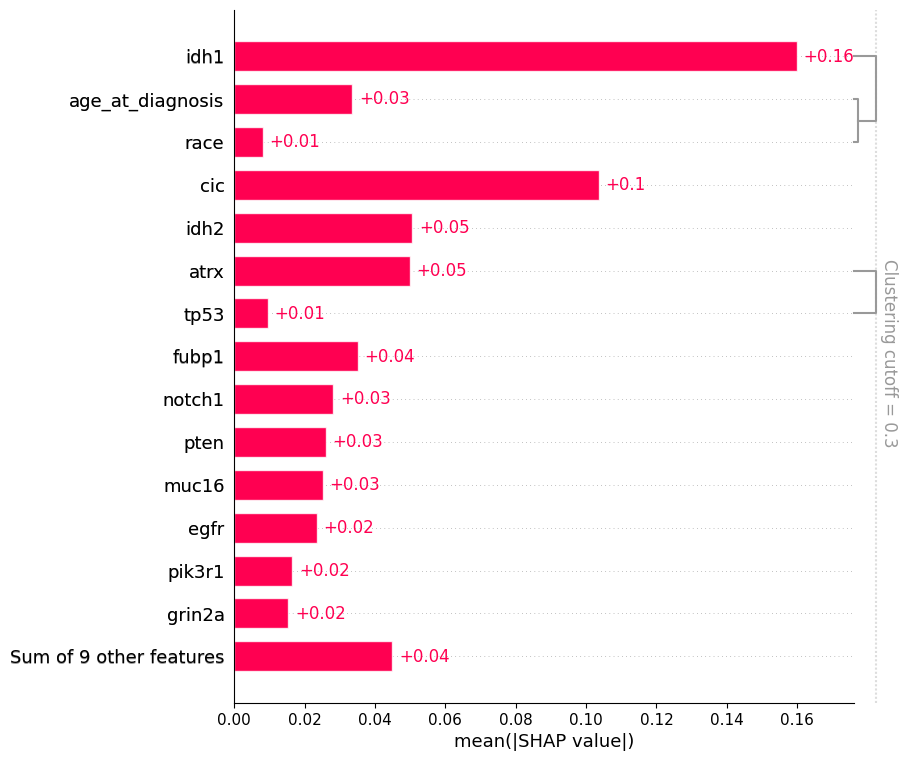

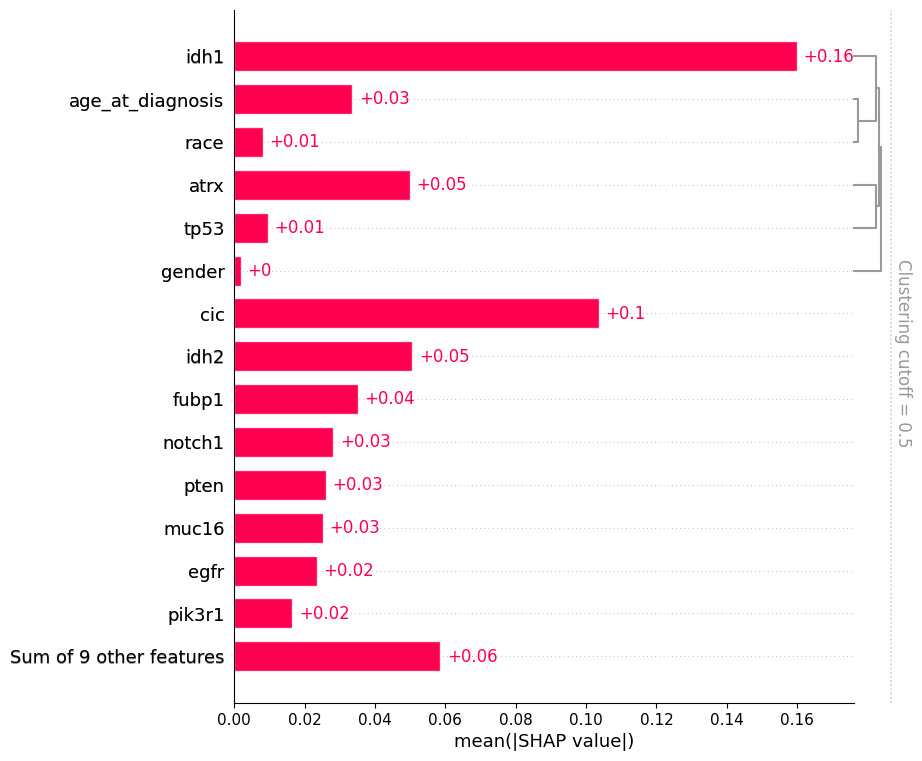

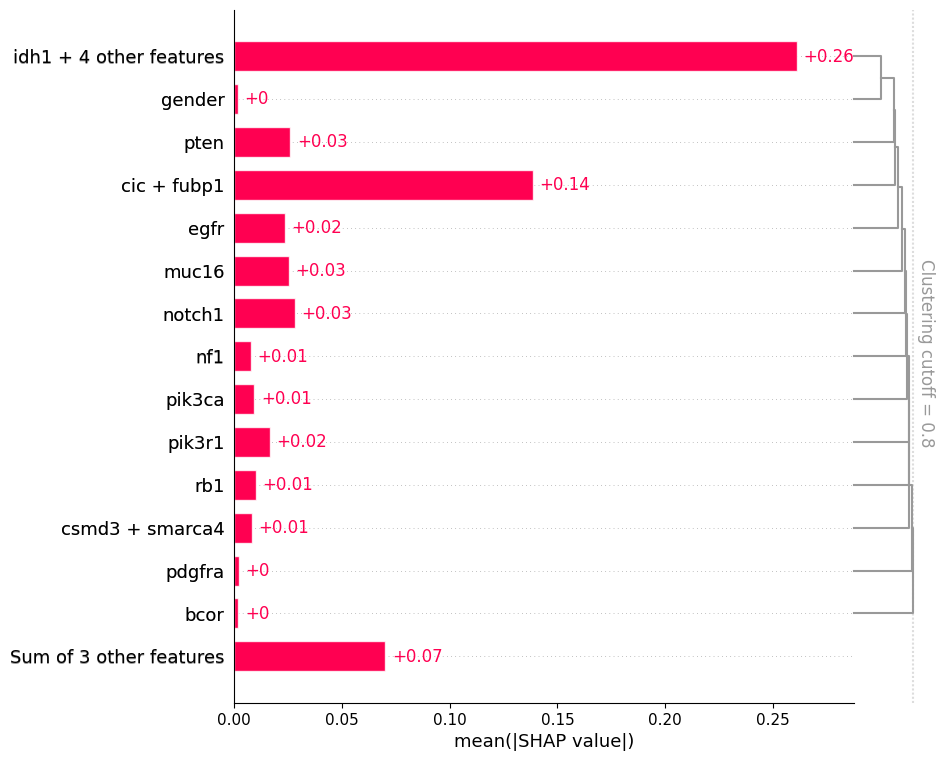

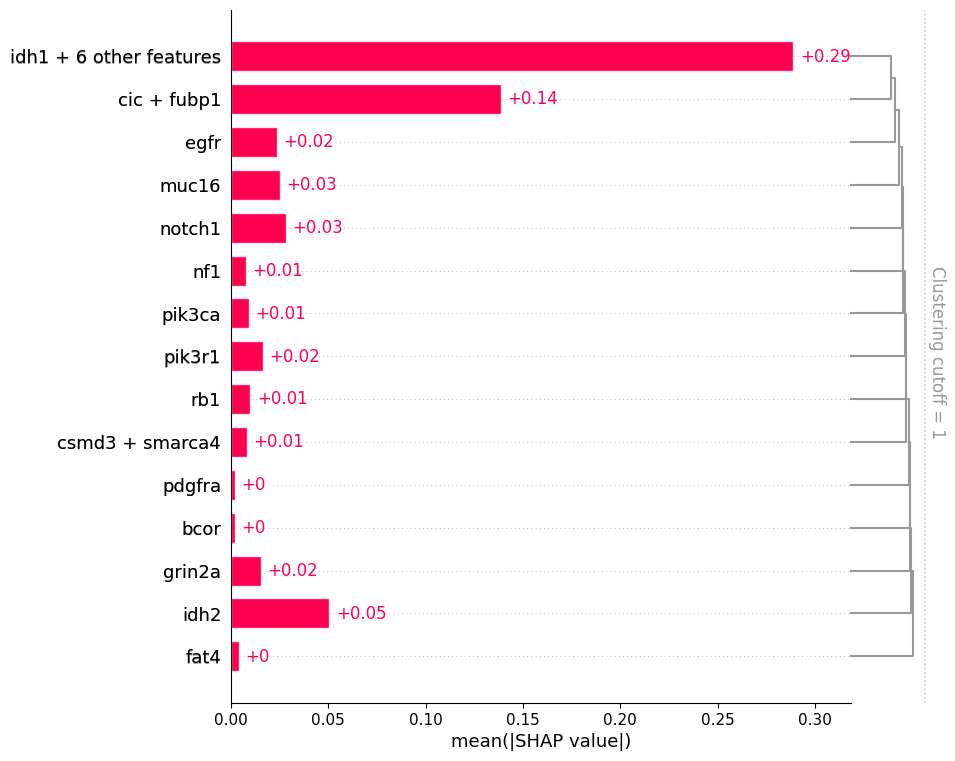

In [65]:

clustering = shap.utils.hclust(X_train)

cutoffs= [0.3, 0.5, 0.8, 1.0]
for c in cutoffs:
    shap.plots.bar(shap_NBG_vals[:, :, 1], clustering=clustering, clustering_cutoff=c, max_display=15) 

https://shap-community.readthedocs.io/en/latest/notebooks/plots/bar.html 

If I read and understand clustering correctly.  
The idea is that tighly clustered features are features that often show up alongside each other in the dataset.  
Such as atrx and tp53 as seen most clearly on the 0.3 cutoff plot.  

That means that I might be able to prune one of the features and not loose too much model performance, assuming a low shap value.  
So removing tp53 might be a good idea.  
Another, very reasonable idea, is to remove race. Since, as noted several times before, the data is extremely skewed towards "white".  
Its most likely due to chance that a given model has picked up on this "relationship" more than anything.  
Obviously one would have to re-validate the model for each feature removal to ensure not too much performance gets lost.  

So in our case the workflow would be something like this:  
Remove tp53 from X_train_standard and X_test_standard  
Retrain Gaussian Naive Bayes model (I just ended up with Gaussian Naive Bayes for shap checking)  
Compare sensitivity/recall with old GNB model  
Check Chi² on predictions, hopefully no significant difference!  
Recheck shap values and recluster. Atrx should ideally increase a bit since tp53 is gone  

Redo the whole procedure with race and hope age_at_diagnosis or possibly idh1 shap values increase  

I'll save that project for a later date.  